In [1]:
import sys
sys.path.append('src/')

import non_adversarial_reproduction.plot_util as plot_util
plot_util.setup_matplotlib()

In [2]:
import json
import pathlib
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.scale
import datetime
import collections


In [3]:
DATA_BASE_DIR = pathlib.Path.cwd() / "data"
RESULTS_BASE_DIR = DATA_BASE_DIR / "results"
RESULTS_DIRS = (
    "ablation_assistant",
    "ablation_simple",
    "book_reviews",
    "essay_persuade",
    "explainlikeimfive",
    "general_prompts",
    "imdb_reviews",
    "writing_prompts",
)
RESULTS_DIRS_WILD = (
    "lmsys_chat",
    "wildchat",
)
PLOT_OUTPUT_DIR = pathlib.Path.cwd() / "plots"
PLOT_OUTPUT_DIR.mkdir(exist_ok=True)

In [4]:
MEMORIZATION_THRESHOLD = 50

MODEL_NAMES = {
    "humans": "Humans",
    "gpt-4o-mini-2024-07-18": "GPT-4o-mini",
    "gpt-4o-2024-05-13": "GPT-4o",
    "gpt-4-turbo-2024-04-09": "GPT-4 Turbo",
    "claude-3-haiku": "Claude 3 Haiku",
    "claude-3.5-sonnet": "Claude 3.5 Sonnet",
    "claude-3-opus": "Claude 3 Opus",
    "llama-3.1-8b-instruct": "Llama 3.1 (8B)",
    "llama-3.1-70b-instruct": "Llama 3.1 (70B)",
    "llama-3.1-405b-instruct": "Llama 3.1 (405B)",
    "gemini-1.5-flash-002": "Gemini 1.5 Flash",
    "gemini-1.5-pro-002": "Gemini 1.5 Pro",
    "o1-mini-2024-09-12": "o1-mini",
    "o1-preview-2024-09-12": "o1-preview",
}
MODEL_ORDER = {
    name: idx for idx, name in enumerate(MODEL_NAMES.keys())
}
TEXT_TYPE_LABELS = {
    "creative": "Creative",
    "argumentative": "Argumentative",
    "expository": "Expository",
}
IMDB_REVIEW_DATE_MIN = datetime.date(2024, 5, 1)
DEFAULT_TEMPERATURE = 0.7

# Axis labels
DISTRIBUTION_YAXIS_LABEL = "Fraction of Texts"
DISTRIBUTION_YAXIS_LABEL_SHORT = "Frac.\\ of Texts"
DISTRIBUTION_XAXIS_LABEL = "Reproduction Length"
FRACTION_XAXIS_LABEL_DISTRIBUTION = "Overlap Rate"
FRACTION_XAXIS_LABEL = "Mean Overlap Rate"
FRACTION_XAXIS_LABEL_SHORT = "Mean Overlap Rate"
FRACTION_XAXIS_LABEL_MEANMEDIAN = "Overlap Rate"  # if we have mean and median
FRACTION_XAXIS_LABEL_CHANGE = "Overlap Rate Change (p.p.)"

SCALE_SWITCH_VALUE = 125  # 99% percentile of reproduction lengths for temperature 0.7

In [5]:
def is_refusal(completion: str) -> bool:
    return (
        len(completion.strip()) < 20
        or completion.lower().startswith("I apologize, but".lower())
        or completion.lower().startswith("I'm sorry, but".lower())
        or completion.lower().startswith("I'm sorry but".lower())
        or completion.lower().startswith("I’m sorry, but".lower())
        or completion.lower().startswith("I am sorry, but".lower())
        or completion.lower().startswith("Sorry, but".lower())
        or completion.lower().startswith("Apologies, but".lower())
        or completion.lower().startswith("I'm sorry for".lower())
        or completion.lower().startswith("As an AI".lower())
        or completion.lower().startswith("I can't assist".lower())
        or completion
        .lower()
        .startswith("I'm not able to provide a story based on that prompt".lower())
        or completion
        .lower()
        .startswith("I cannot fulfill your request".lower())
        or completion.lower().startswith("I can't satisfy your request".lower())
        or completion
        .lower()
        .startswith("I must apologize, but I cannot provide a response".lower())
        or completion.lower().startswith("I cannot provide a response".lower())
        or completion
        .lower()
        .startswith("I cannot provide a story that".lower())
    )

# Main matter

## Results overviews

In [6]:
overview_max_x = 0.2

### Our models

In [7]:
current_models = (
    # "humans",
    "gpt-4o-mini-2024-07-18", "gpt-4o-2024-05-13",
    "claude-3-haiku", "claude-3.5-sonnet", "claude-3-opus",
    "llama-3.1-8b-instruct", "llama-3.1-405b-instruct",
    "gemini-1.5-flash-002", "gemini-1.5-pro-002",
    # "o1-mini-2024-09-12", "o1-preview-2024-09-12",
)
current_ignored_settings = (
    "ablation_assistant",
    "ablation_simple",
)

current_data = []
for setting in tqdm.tqdm(RESULTS_DIRS):
    if setting in current_ignored_settings:
        continue
    for result_file in tuple((RESULTS_BASE_DIR / setting).glob("*.jsonl")):
        model, temperature_raw = result_file.stem.split("_")
        temperature = float(temperature_raw[len("temp"):]) if temperature_raw != "tempX.X" else None
        if temperature is not None and temperature != DEFAULT_TEMPERATURE:
            continue
        if model not in current_models:
            continue
        with open(result_file, "r") as f:
            for line in f:
                raw_data = json.loads(line)
                if "error" in raw_data:
                    continue
                if is_refusal(raw_data["completion"]):
                    continue
                # Special case, drop old IMDB reviews
                if setting == "imdb_reviews" and model == "humans" and datetime.date.fromisoformat(raw_data["review_date"]) < IMDB_REVIEW_DATE_MIN:
                    continue
                memorized_fraction = np.mean(np.array(raw_data["memorized_chars"]) >= MEMORIZATION_THRESHOLD)
                current_data.append({
                    "model": model,
                    "type": raw_data["type"],
                    "memorized_fraction": memorized_fraction,
                    "text_type": raw_data["text_type"],
                })

df_overview_ours = pd.DataFrame(current_data)
del current_data

100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


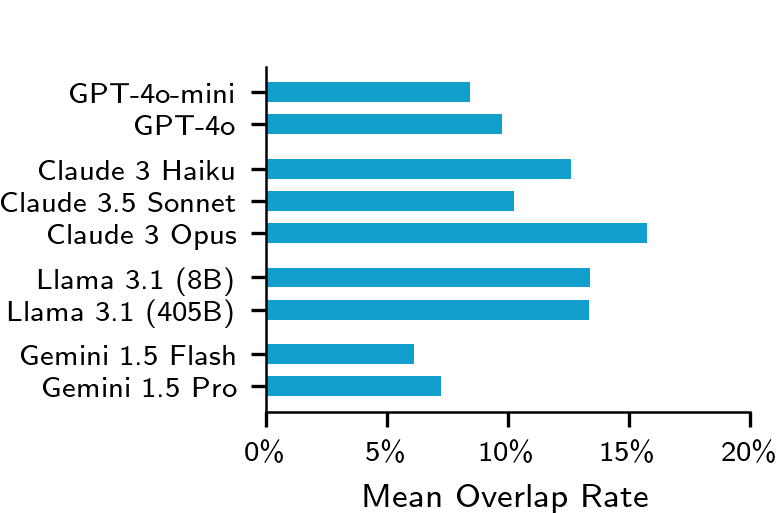

In [8]:

# Calculate mean first per type, then per text type, and only then for all (to ensure a fair comparison)
df_mean = df_overview_ours.groupby(["model", "text_type", "type"]).agg({"memorized_fraction": "mean"}).groupby(["model", "text_type"]).agg("mean").groupby("model").agg("mean")
df_mean = df_mean.reindex(sorted(df_mean.index, key=lambda x: MODEL_ORDER[x], reverse=True))
# For median, use the global median
df_median = df_overview_ours.groupby(["model"]).agg({"memorized_fraction": "median"})
df_median = df_median.reindex(sorted(df_median.index, key=lambda x: MODEL_ORDER[x], reverse=True))

fig, ax = plt.subplots(figsize=plot_util.FIGURE_SIZE_HALF_IN)

space_at_indices = (2, 4, 7)
bar_size = plot_util.BAR_WIDTH
extra_space = (1 - bar_size)
y_ticks = np.arange(len(df_mean.index), dtype=float)
for space_idx in space_at_indices:
    y_ticks[space_idx:] += extra_space

bars = ax.barh(y_ticks, df_mean["memorized_fraction"], color="C0", label="Mean", height=bar_size)
ax.set_yticks(y_ticks)
ax.set_yticklabels([MODEL_NAMES[model] for model in df_mean.index])

ax.set_xlabel(FRACTION_XAXIS_LABEL)
ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylabel(None)
ax.set_xlim(0, overview_max_x)

legend_handles, legend_labels = ax.get_legend_handles_labels()
legend_handles = [plot_util.proxy_patch()]
legend_labels = [""]
fig.legend(legend_handles, legend_labels, loc="outside upper center", ncol=2)

plot_util.resize_figure_with_legend(fig)

plt.show()

fig.savefig(PLOT_OUTPUT_DIR / "overview_ours.pdf")
plt.close(fig)

In [9]:
df_mean

,memorized_fraction
model,
gemini-1.5-pro-002,0.072283
gemini-1.5-flash-002,0.061124
llama-3.1-405b-instruct,0.133395
llama-3.1-8b-instruct,0.134056
claude-3-opus,0.157566
claude-3.5-sonnet,0.102411
claude-3-haiku,0.125867
gpt-4o-2024-05-13,0.097636
gpt-4o-mini-2024-07-18,0.084476


### Wild

In [10]:
current_data = []
for setting in tqdm.tqdm(RESULTS_DIRS_WILD):
    for result_file in tuple((RESULTS_BASE_DIR / setting).glob("*.jsonl")):
        model, temperature_raw = result_file.stem.split("_")
        temperature = float(temperature_raw[len("temp"):]) if temperature_raw != "tempX.X" else None
        with open(result_file, "r") as f:
            for line in f:
                raw_data = json.loads(line)
                if "error" in raw_data:
                    continue
                if is_refusal(raw_data["completion"]):
                    continue
                memorized_fraction = np.mean(np.array(raw_data["memorized_chars"]) >= MEMORIZATION_THRESHOLD)
                current_data.append({
                    "model": model,
                    "memorized_fraction": memorized_fraction,
                    "dataset": setting,
                })

df_overview_wild = pd.DataFrame(current_data)
del current_data

100%|██████████| 2/2 [00:17<00:00,  8.60s/it]


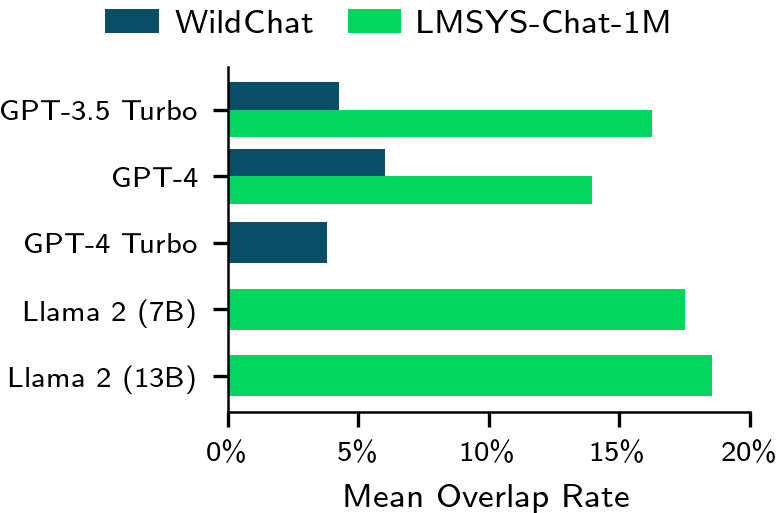

In [11]:
fig, ax = plt.subplots(figsize=plot_util.FIGURE_SIZE_HALF_IN)

WILD_LEGEND_MAP = {
    "wildchat": "WildChat",
    "lmsys_chat": "LMSYS-Chat-1M",
}

# Unify model names
MODEL_MERGE_MAP = {
    "gpt-3.5-turbo-0125": "gpt-3.5-turbo",
    "gpt-3.5-turbo-0301": "gpt-3.5-turbo",
    "gpt-3.5-turbo-0613": "gpt-3.5-turbo",
    "gpt-4-0314": "gpt-4",
    "gpt-4-0125-preview": "gpt-4-turbo-preview",
    "gpt-4-1106-preview": "gpt-4-turbo-preview",
}
model_names_wild = {
    "gpt-3.5-turbo": "GPT-3.5 Turbo",
    "gpt-4": "GPT-4",
    "gpt-4-turbo-preview": "GPT-4 Turbo",
    "llama-2-7b-chat": "Llama 2 (7B)",
    "llama-2-13b-chat": "Llama 2 (13B)",
}
model_order_wild = {
    name: idx for idx, name in enumerate(model_names_wild.keys())
}
dataset_colors = {
    "wildchat": "C3",
    "lmsys_chat": "C4",
}
dataset_hatches = {
    "wildchat": "",
    "lmsys_chat": "",
}

df_plot = df_overview_wild.copy()
df_plot["model"] = df_plot["model"].replace(MODEL_MERGE_MAP)
df_mean = df_plot.groupby(["model", "dataset"]).agg({"memorized_fraction": "mean"}).unstack()
df_mean.columns = df_mean.columns.droplevel()
df_mean = df_mean.reindex(sorted(df_mean.index, key=lambda x: model_order_wild[x], reverse=True))

df_median = df_plot.groupby(["model", "dataset"]).agg({"memorized_fraction": "median"})

bar_size_half = plot_util.BAR_WIDTH / (2 - 0.5)
for idx, (dataset_key, dataset_label) in enumerate(WILD_LEGEND_MAP.items()):
    is_single = df_mean.isna().any(axis="columns")
    xs = np.arange(len(df_mean)) - np.where(is_single, 0, idx * bar_size_half - bar_size_half / 2)
    heights = np.where(is_single, plot_util.BAR_WIDTH, bar_size_half)
    bars = ax.barh(
        xs,
        df_mean[dataset_key],
        color=dataset_colors[dataset_key],
        label=dataset_label,
        height=heights,
        hatch=dataset_hatches[dataset_key],
    )

ax.set_xlabel(FRACTION_XAXIS_LABEL)
ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_yticks(np.arange(len(df_mean.index)))
ax.set_yticklabels([model_names_wild[model] for model in df_mean.index], ha="right")
ax.set_ylabel(None)
ax.set_xlim(0, overview_max_x)

legend_axes, legend_labels = ax.get_legend_handles_labels()
fig.legend(legend_axes, legend_labels, loc="outside upper center", ncol=2)

plot_util.resize_figure_with_legend(fig)

plt.show()
fig.savefig(PLOT_OUTPUT_DIR / "overview_wild.pdf")

plt.close(fig)

In [12]:
# Counts per dataset
df_overview_wild.groupby(["dataset"]).size()

dataset
lmsys_chat    14675
wildchat      58164
dtype: int64

## More details

In [13]:
current_models = (
    "gpt-4o-mini-2024-07-18", "gpt-4o-2024-05-13", "gpt-4-turbo-2024-04-09",
    "claude-3-haiku", "claude-3.5-sonnet", "claude-3-opus",
    "llama-3.1-8b-instruct" ,"llama-3.1-70b-instruct" ,"llama-3.1-405b-instruct",
    "gemini-1.5-flash-002", "gemini-1.5-pro-002",
    # "o1-mini-2024-09-12", "o1-preview-2024-09-12",
)
subset_models = (
    "gpt-4o-mini-2024-07-18", "gpt-4o-2024-05-13",
    "claude-3-haiku", "claude-3.5-sonnet", "claude-3-opus",
    "llama-3.1-8b-instruct", "llama-3.1-405b-instruct",
    "gemini-1.5-flash-002", "gemini-1.5-pro-002",
    # "o1-mini-2024-09-12", "o1-preview-2024-09-12",
)
current_ignored_settings = (
    "ablation_assistant",
    "ablation_simple",
)

current_data = []
for setting in tqdm.tqdm(RESULTS_DIRS):
    if setting in current_ignored_settings:
        continue
    for result_file in tuple((RESULTS_BASE_DIR / setting).glob("*.jsonl")):
        model, temperature_raw = result_file.stem.split("_")
        temperature = float(temperature_raw[len("temp"):]) if temperature_raw != "tempX.X" else None
        if temperature is not None and temperature != DEFAULT_TEMPERATURE:
            continue
        if model not in current_models:
            continue
        with open(result_file, "r") as f:
            for line in f:
                raw_data = json.loads(line)
                if "error" in raw_data:
                    continue
                if is_refusal(raw_data["completion"]):
                    continue
                # Special case, drop old IMDB reviews
                if setting == "imdb_reviews" and model == "humans" and datetime.date.fromisoformat(raw_data["review_date"]) < IMDB_REVIEW_DATE_MIN:
                    continue
                memorized_fraction = np.mean(np.array(raw_data["memorized_chars"]) >= MEMORIZATION_THRESHOLD)
                current_data.append({
                    "model": model,
                    "type": raw_data["type"],
                    "memorized_fraction": memorized_fraction,
                    "text_type": raw_data["text_type"],
                })

df_details = pd.DataFrame(current_data)
del current_data

100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


In [14]:
TYPE_TEXT_TYPE_MAP = {
    prompt_type: df_details[df_details["type"] == prompt_type]["text_type"].unique()[0]
    for prompt_type in df_details["type"].unique()
}

TEXT_TYPE_COLOR_MAP = {
    key: f"C{idx}" for idx, key in enumerate(TEXT_TYPE_LABELS.keys())
}

TEXT_TYPE_LINESTYLE_MAP = {
    "creative": "dotted",
    "argumentative": "dashed",
    "expository": "solid",
}

TYPE_LABEL_MAP = {
    "writing_prompts": "WritingPrompts",
    "blog_travel": "Blog (Travel)",
    "blog_personal": "Blog (Personal)",
    "letter": "Fictional Letter",
    "satire": "Satire",

    "explainlikeimfive": "ELI5",
    "news_known": "News (Known)",
    "news_unseen": "News (Unseen)",
    "tutorial": "Tutorial",
    "encyclopedia": "Encyclopedia",

    "essay_persuade": "Essays",
    "imdb_reviews": "Reviews (Movies)",
    "book_reviews": "Reviews (Books)",
    "recommendation_letter": "Recommendation Letter",
    "sop": "Statement of Purpose",
}

details_max_x = 0.3

### Text types

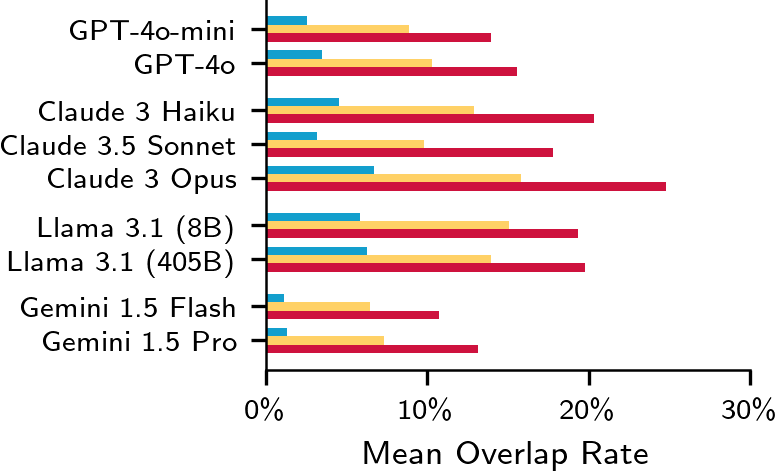

In [15]:
fig, ax = plt.subplots(figsize=plot_util.FIGURE_SIZE_HALF_IN)
# Only select models in subset_models
df_details_current = df_details[df_details["model"].isin(subset_models)]

df_mean = df_details_current.groupby(["model", "text_type", "type"]).agg({"memorized_fraction": "mean"})
df_mean = df_mean.groupby(["model", "text_type"]).agg({"memorized_fraction": "mean"}).unstack()
df_mean.columns = df_mean.columns.droplevel()
df_mean = df_mean.reindex(sorted(df_mean.index, key=lambda x: MODEL_ORDER[x], reverse=True))

df_median = df_details_current.groupby(["model", "text_type"]).agg({"memorized_fraction": "median"}).unstack()
df_median.columns = df_median.columns.droplevel()
df_median = df_median.reindex(sorted(df_median.index, key=lambda x: MODEL_ORDER[x], reverse=True))

space_at_indices = (2, 4, 7)
bar_size = plot_util.BAR_WIDTH
extra_space = (1 - bar_size)
y_ticks = np.arange(len(df_mean.index), dtype=float)
for space_idx in space_at_indices:
    y_ticks[space_idx:] += extra_space

bar_size = plot_util.BAR_WIDTH / (3 - 0.5)
for idx, text_type in enumerate(TEXT_TYPE_LABELS.keys()):
    bars = ax.barh(
        y_ticks - idx * bar_size + bar_size,
        df_mean[text_type],
        color=f"C{idx}",
        label=TEXT_TYPE_LABELS[text_type],
        height=bar_size,
    )

ax.set_xlabel(FRACTION_XAXIS_LABEL)
ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_yticks(y_ticks)
ax.set_yticklabels(
    [MODEL_NAMES[model] for model in df_mean.index],
    rotation=0,
    ha="right"
)
ax.set_ylabel(None)
ax.set_xlim(0, details_max_x)

plt.show()

fig.savefig(PLOT_OUTPUT_DIR / "details_texttypes.pdf")
plt.close(fig)

In [16]:
df_mean["expository"] / df_mean["creative"]

model
gemini-1.5-pro-002         10.358660
gemini-1.5-flash-002        9.562001
llama-3.1-405b-instruct     3.167767
llama-3.1-8b-instruct       3.323971
claude-3-opus               3.712912
claude-3.5-sonnet           5.642366
claude-3-haiku              4.475179
gpt-4o-2024-05-13           4.487875
gpt-4o-mini-2024-07-18      5.475063
dtype: float64

### Types

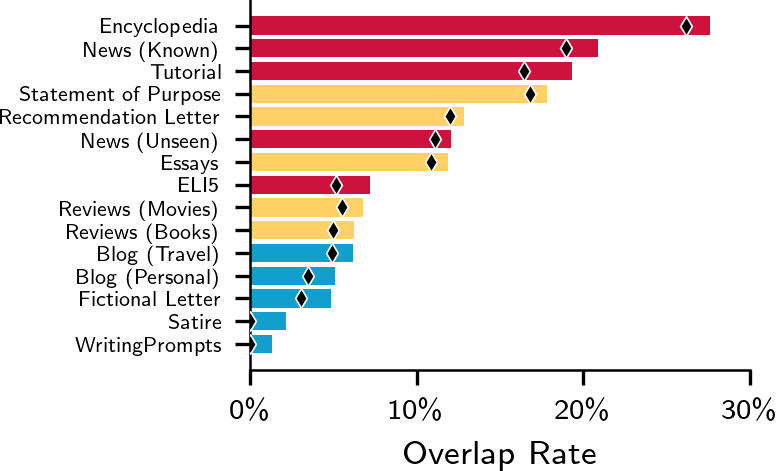

In [17]:
df_plot = df_details.groupby(["type"]).agg({"memorized_fraction": ("mean", "median")}).droplevel(0, axis=1)
df_plot = df_plot.sort_values("mean", ascending=True)

fig, ax = plt.subplots(figsize=plot_util.FIGURE_SIZE_HALF_IN)

bars = ax.barh(
    [TYPE_LABEL_MAP[prompt_type] for prompt_type in df_plot.index],
    df_plot["mean"],
    color=[TEXT_TYPE_COLOR_MAP[TYPE_TEXT_TYPE_MAP[prompt_type]] for prompt_type in df_plot.index],
)

# Add median
for idx, bar in enumerate(bars):
    median_dot = ax.scatter(
        df_plot["median"].iloc[idx],
        bar.get_y() + bar.get_height() / 2,
        marker="d",
        color="black",
        edgecolor="white",
        zorder=10,
        s=11,
        lw=0.4,
    )

ax.set_xlabel(FRACTION_XAXIS_LABEL_MEANMEDIAN)
ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylabel(None)
# Reduce y-axis font size a bit (get font size from rcParams)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticklabels(), fontsize=matplotlib.rcParams["ytick.labelsize"] - 2)
ax.set_xlim(0, details_max_x)

legend_handles = [
    # Get first correct bar from bars
    (bar for idx, bar in enumerate(bars) if TYPE_TEXT_TYPE_MAP[df_plot.index[idx]] == text_type).__next__()
    for text_type in TEXT_TYPE_COLOR_MAP.keys()
]
legend_labels = [TEXT_TYPE_LABELS[text_type] for text_type in TEXT_TYPE_COLOR_MAP.keys()]

legend_handles.append(median_dot)
legend_labels.append("Median")

fig.savefig(PLOT_OUTPUT_DIR / "details_types.pdf")
plt.show()

plt.close(fig)

In [18]:
fig_legend = plt.figure(figsize=(plot_util.FIGURE_SIZE_FULL_IN[0], 14.0 / plot_util.TEX_PT_PER_IN))
fig_legend.legend(legend_handles, legend_labels, loc="center", ncol=4)
plt.show()
fig_legend.savefig(PLOT_OUTPUT_DIR / "details_legend.pdf")
plt.close(fig_legend)


<Figure size 1647.88x58.1154 with 0 Axes>

In [19]:
df_plot

,mean,median
type,,
writing_prompts,0.013214,0.000000
satire,0.021691,0.000000
letter,0.048521,0.030500
blog_personal,0.050751,0.034869
blog_travel,0.061780,0.048760
book_reviews,0.062405,0.049829
imdb_reviews,0.067581,0.054822
explainlikeimfive,0.072122,0.051513
essay_persuade,0.118966,0.108368


## Distribution plots

In [20]:
current_models = (
    "gpt-4o-mini-2024-07-18", "gpt-4o-2024-05-13", "gpt-4-turbo-2024-04-09",
    "claude-3-haiku", "claude-3.5-sonnet", "claude-3-opus",
    "llama-3.1-8b-instruct" ,"llama-3.1-70b-instruct" ,"llama-3.1-405b-instruct",
    "gemini-1.5-flash-002", "gemini-1.5-pro-002",
    "o1-mini-2024-09-12", "o1-preview-2024-09-12",
    "humans",
)
subset_models = (
    "gpt-4o-mini-2024-07-18", "gpt-4o-2024-05-13", "gpt-4-turbo-2024-04-09",
    "claude-3-haiku", "claude-3.5-sonnet", "claude-3-opus",
    "llama-3.1-8b-instruct" ,"llama-3.1-70b-instruct" ,"llama-3.1-405b-instruct",
    "gemini-1.5-flash-002", "gemini-1.5-pro-002",
)

current_ignored_settings = (
    "ablation_assistant",
    "ablation_simple",
)

current_data = []
for setting in tqdm.tqdm(RESULTS_DIRS):
    if setting in current_ignored_settings:
        continue
    for result_file in tuple((RESULTS_BASE_DIR / setting).glob("*.jsonl")):
        model, temperature_raw = result_file.stem.split("_")
        temperature = float(temperature_raw[len("temp"):]) if temperature_raw != "tempX.X" else None
        if temperature is not None and temperature != DEFAULT_TEMPERATURE and (model != "humans" and (not model.startswith("o1"))):
            continue
        if model not in current_models:
            continue
        with open(result_file, "r") as f:
            for line in f:
                raw_data = json.loads(line)
                if "error" in raw_data:
                    continue
                # Special case, drop old IMDB reviews
                if setting == "imdb_reviews" and model == "humans" and datetime.date.fromisoformat(raw_data["review_date"]) < IMDB_REVIEW_DATE_MIN:
                    continue
                if is_refusal(raw_data["completion"]):
                    continue
                memorized_chars = np.array(raw_data["memorized_chars"])
                memorized_fraction = np.mean(memorized_chars >= MEMORIZATION_THRESHOLD)
                current_data.append({
                    "model": model,
                    "type": raw_data["type"],
                    "memorized_fraction": memorized_fraction,
                    "memorized_chars": memorized_chars,
                    "temperature": temperature,
                    "text_type": raw_data["text_type"],
                })

df_distributions = pd.DataFrame(current_data)
del current_data

100%|██████████| 8/8 [00:48<00:00,  6.07s/it]


### For fraction memorized

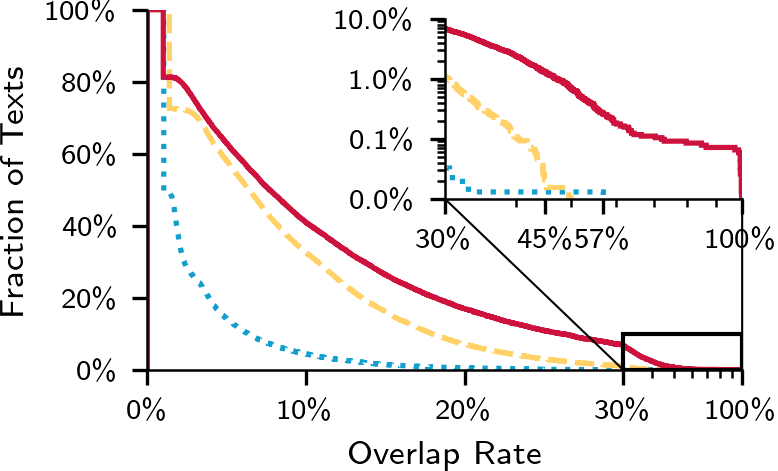

In [21]:
# Plot CDF of memorized fraction, sort-of
df_distributions_fraction = df_distributions.copy()
df_distributions_fraction = df_distributions_fraction[df_distributions_fraction["model"].isin(subset_models)]

def calculate_chains_icdf(data: pd.DataFrame) -> np.ndarray:
    memorized_fraction_counts = data["memorized_fraction"].value_counts().sort_index()
    assert len(data) == np.sum(memorized_fraction_counts.values)
    memorized_fraction_cdf = np.cumsum(memorized_fraction_counts.values[::-1])[::-1] / len(data)
    memorized_fraction_cdf_xs = memorized_fraction_counts.index.values
    assert memorized_fraction_cdf_xs[-1] < 1.0
    memorized_fraction_cdf_xs = np.concatenate((memorized_fraction_cdf_xs, [1.0]))
    return pd.Series({
        "memorized_fraction_cdf_xs": memorized_fraction_cdf_xs,
        "memorized_fraction_cdf": memorized_fraction_cdf
    })

df_distributions_fraction = df_distributions_fraction.groupby(["text_type"]).apply(calculate_chains_icdf, include_groups=False).reset_index()
df_distributions_fraction = df_distributions_fraction.set_index("text_type")

fig, ax = plt.subplots(figsize=plot_util.FIGURE_SIZE_HALF_IN)

for text_type in TEXT_TYPE_LABELS.keys():
    ax.stairs(
        values=df_distributions_fraction.loc[text_type]["memorized_fraction_cdf"],
        edges=df_distributions_fraction.loc[text_type]["memorized_fraction_cdf_xs"],
        fill=False,
        color=TEXT_TYPE_COLOR_MAP[text_type],
        label=TEXT_TYPE_LABELS[text_type],
        linestyle=TEXT_TYPE_LINESTYLE_MAP[text_type]
    )

SCALE_MIN = 0.0
SCALE_SPLIT = 0.3
SCALE_MAX = 1.0
SPLIT_FRACTION = 0.8

# Custom x-axis scaling:
# Do a linear scale from SCALE_MIN to SCALE_SPLIT and a log scale from SCALE_SPLIT to SCALE_MAX
# Use SPLIT_FRACTION to determine the split (fraction of full [0,1] range that belongs to the linear part)
def scale_func(x):
    with np.errstate(divide="ignore"):
        return np.where(
            x < SCALE_SPLIT,
            SPLIT_FRACTION * (x - SCALE_MIN) / (SCALE_SPLIT - SCALE_MIN),
            SPLIT_FRACTION + (1 - SPLIT_FRACTION) * np.log(x / SCALE_SPLIT) / np.log(SCALE_MAX / SCALE_SPLIT)
        )

def scale_func_inv(x):
    return np.where(
        x < SPLIT_FRACTION,
        SCALE_MIN + (SCALE_SPLIT - SCALE_MIN) * x / SPLIT_FRACTION,
        SCALE_SPLIT * np.exp((x - SPLIT_FRACTION) * np.log(SCALE_MAX / SCALE_SPLIT) / (1 - SPLIT_FRACTION))
    )

ax.set_xlim(SCALE_MIN, SCALE_MAX)
ax.set_xscale(matplotlib.scale.FuncScale(axis=ax, functions=(scale_func, scale_func_inv)))
ax.set_xticks((SCALE_MIN, 0.1, 0.2, SCALE_SPLIT, SCALE_MAX), minor=False)
ax.set_xticks((np.linspace(SCALE_SPLIT, SCALE_MAX, num=8)), minor=True)
ax.set_xlabel(FRACTION_XAXIS_LABEL_DISTRIBUTION)
ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))

ax.set_ylim(0, 1)
ax.set_ylabel(DISTRIBUTION_YAXIS_LABEL)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))

# Inset axes for second part
ax_ins = ax.inset_axes([0.5, 0.475, 0.5, 0.5])
for text_type in TEXT_TYPE_LABELS.keys():
    ax_ins.stairs(
        values=df_distributions_fraction.loc[text_type]["memorized_fraction_cdf"],
        edges=df_distributions_fraction.loc[text_type]["memorized_fraction_cdf_xs"],
        fill=False,
        color=TEXT_TYPE_COLOR_MAP[text_type],
        linestyle=TEXT_TYPE_LINESTYLE_MAP[text_type]
    )
ax_ins.set_xlim(SCALE_SPLIT, SCALE_MAX)
ax_ins.set_ylim(0.0001, 0.1)
ax_ins.loglog()
ins_xticks = (SCALE_SPLIT, 0.45, 0.57, SCALE_MAX)
ax_ins.set_xticks(ins_xticks, minor=False)
ax_ins.set_xticklabels(ins_xticks)
ax_ins.set_xticklabels((), minor=True)
ax_ins.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))
ax_ins.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=1))

rect, connects = ax.indicate_inset_zoom(ax_ins, edgecolor="black", lw=1.0, alpha=1.0)
for idx, connect in enumerate(connects):
    connect.set_linewidth(0.5)
    connect.set_visible(idx % 2 == 0)

legend_handles, legend_labels = ax.get_legend_handles_labels()

plt.show()
fig.savefig(PLOT_OUTPUT_DIR / f"distribution_fraction.pdf")

plt.close(fig)


In [22]:
fig_legend = plt.figure(figsize=(plot_util.FIGURE_SIZE_FULL_IN[0], 14.0 / plot_util.TEX_PT_PER_IN))
fig_legend.legend(legend_handles, legend_labels, loc="center", ncol=3)
plt.show()
fig_legend.savefig(PLOT_OUTPUT_DIR / "distribution_legend.pdf")
plt.close(fig_legend)

<Figure size 1647.88x58.1154 with 0 Axes>

### For sequence length

213
174
1170


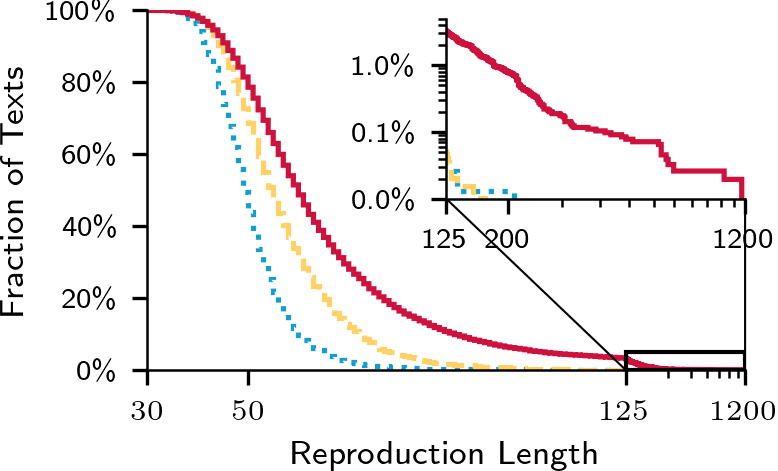

In [23]:
# Plot (inverse) CDF of memorized sequence length, sort-of
df_distributions_count = df_distributions.copy()
df_distributions_count = df_distributions_count[df_distributions_count["model"].isin(subset_models)]

def calculate_chains_icdf(data: pd.DataFrame) -> np.ndarray:
    max_memorized = data["memorized_chars"].apply(max)
    max_memorized_counts = np.bincount(max_memorized)
    assert len(data) == np.sum(max_memorized_counts)
    max_memorized_cdf = np.cumsum(max_memorized_counts) / len(data)
    max_memorized_icdf = 1.0 - max_memorized_cdf
    return pd.Series({"max_memorized_icdf": max_memorized_icdf})

df_distributions_count = df_distributions_count.groupby(["text_type"]).apply(calculate_chains_icdf, include_groups=False).reset_index()
df_distributions_count = df_distributions_count.set_index("text_type")

fig, ax = plt.subplots(figsize=plot_util.FIGURE_SIZE_HALF_IN)

for text_type in TEXT_TYPE_LABELS.keys():
    ax.stairs(
        values=df_distributions_count.loc[text_type]["max_memorized_icdf"],
        fill=False,
        color=TEXT_TYPE_COLOR_MAP[text_type],
        label=TEXT_TYPE_LABELS[text_type],
        linestyle=TEXT_TYPE_LINESTYLE_MAP[text_type]
    )

SCALE_MIN = 30
SCALE_SPLIT = SCALE_SWITCH_VALUE
SCALE_MAX = 1200
SPLIT_FRACTION = 0.8

# Custom x-axis scaling:
# Do a linear scale from SCALE_MIN to SCALE_SPLIT and a log scale from SCALE_SPLIT to SCALE_MAX
# Use SPLIT_FRACTION to determine the split (fraction of full [0,1] range that belongs to the linear part)
def scale_func(x):
    with np.errstate(divide="ignore"):
        return np.where(
            x < SCALE_SPLIT,
            SPLIT_FRACTION * (x - SCALE_MIN) / (SCALE_SPLIT - SCALE_MIN),
            SPLIT_FRACTION + (1 - SPLIT_FRACTION) * np.log(x / SCALE_SPLIT) / np.log(SCALE_MAX / SCALE_SPLIT)
        )

def scale_func_inv(x):
    return np.where(
        x < SPLIT_FRACTION,
        SCALE_MIN + (SCALE_SPLIT - SCALE_MIN) * x / SPLIT_FRACTION,
        SCALE_SPLIT * np.exp((x - SPLIT_FRACTION) * np.log(SCALE_MAX / SCALE_SPLIT) / (1 - SPLIT_FRACTION))
    )

ax.set_xlim(SCALE_MIN, SCALE_MAX)
ax.set_xscale(matplotlib.scale.FuncScale(axis=ax, functions=(scale_func, scale_func_inv)))
ax.set_xticks((SCALE_MIN, MEMORIZATION_THRESHOLD, SCALE_SPLIT, SCALE_MAX), minor=False)
ax.set_xlabel(DISTRIBUTION_XAXIS_LABEL)
ax.set_xticks((np.linspace(SCALE_SPLIT, SCALE_MAX, num=8)), minor=True)

ax.set_ylim(0, 1)
ax.set_ylabel(DISTRIBUTION_YAXIS_LABEL)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))

# Inset axes for second part
ax_ins = ax.inset_axes([0.5, 0.475, 0.5, 0.5])
for text_type in TEXT_TYPE_LABELS.keys():
    ax_ins.stairs(
        values=df_distributions_count.loc[text_type]["max_memorized_icdf"],
        fill=False,
        color=TEXT_TYPE_COLOR_MAP[text_type],
        linestyle=TEXT_TYPE_LINESTYLE_MAP[text_type]
    )
    print(np.argmax(df_distributions_count.loc[text_type]["max_memorized_icdf"] == 0.0))
ax_ins.set_xlim(SCALE_SPLIT, SCALE_MAX)
ax_ins.set_ylim(0.0001, 0.05)
ax_ins.loglog()
ins_xticks = (SCALE_SPLIT, 200, SCALE_MAX)
ax_ins.set_xticks(ins_xticks, minor=False)
ax_ins.set_xticks(np.linspace(200, SCALE_MAX, num=11), minor=True)
ax_ins.set_xticklabels(ins_xticks)
ax_ins.set_xticklabels((), minor=True)
ax_ins.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=1))

rect, connects = ax.indicate_inset_zoom(ax_ins, edgecolor="black", lw=1.0, alpha=1.0)
for idx, connect in enumerate(connects):
    connect.set_linewidth(0.5)
    connect.set_visible(idx % 2 == 0)

plt.show()
fig.savefig(PLOT_OUTPUT_DIR / f"distribution_count.pdf")

plt.close(fig)

### Fraction for all models (appendix)

claude-3-haiku
creative 209
argumentative 114
expository 1024


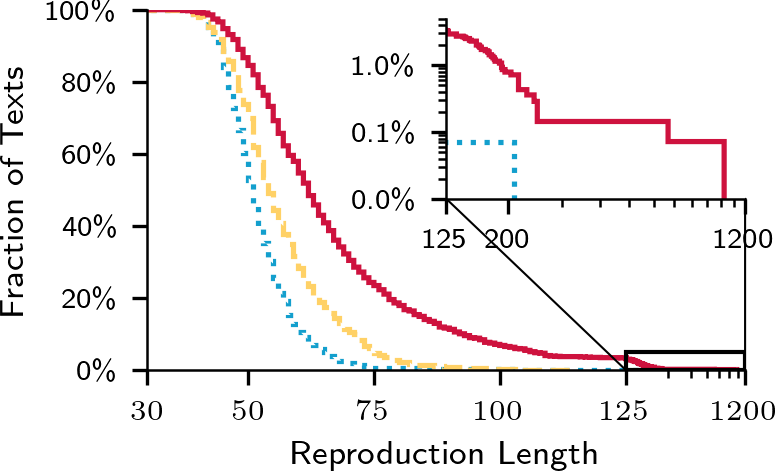

claude-3-opus
creative 213
argumentative 136
expository 1170


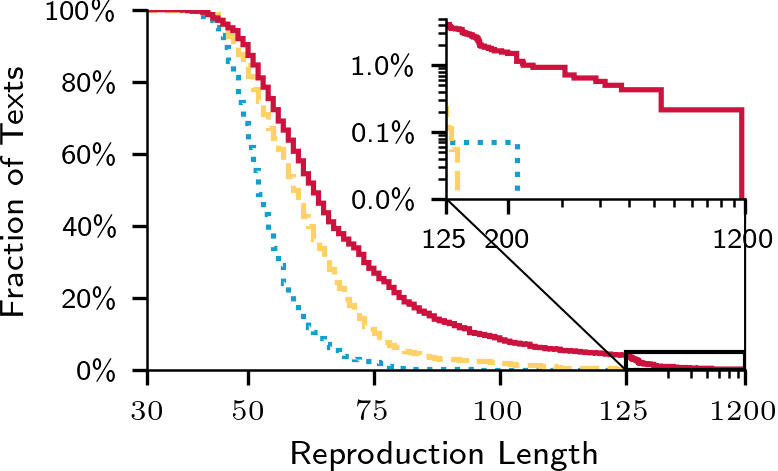

claude-3.5-sonnet
creative 105
argumentative 115
expository 324


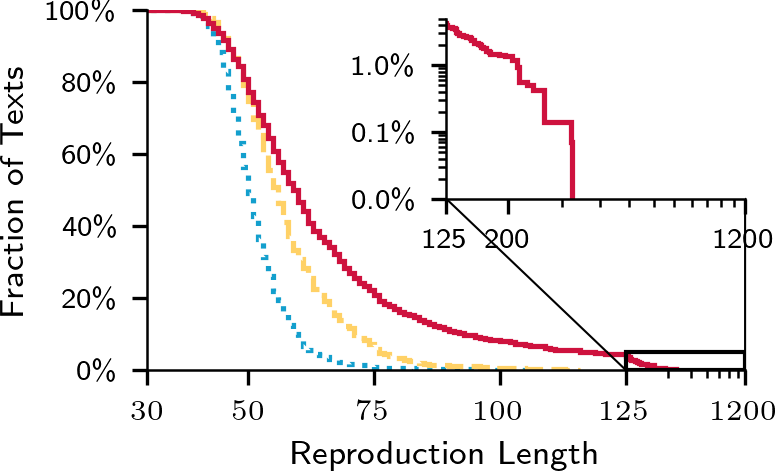

gemini-1.5-flash-002
creative 86
argumentative 86
expository 237


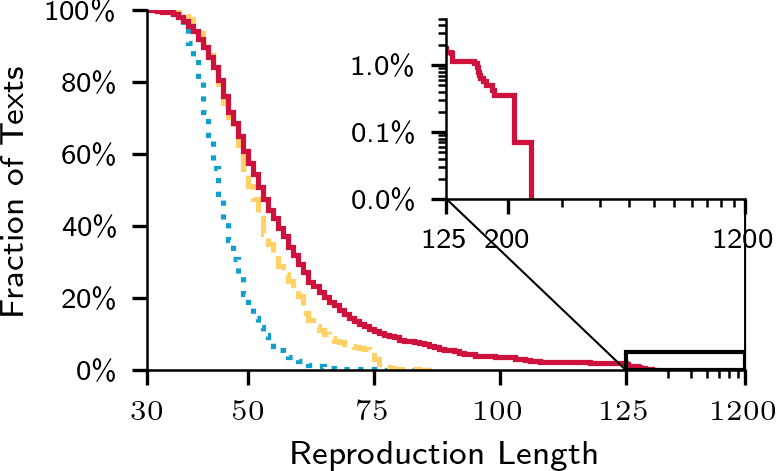

gemini-1.5-pro-002
creative 73
argumentative 107
expository 306


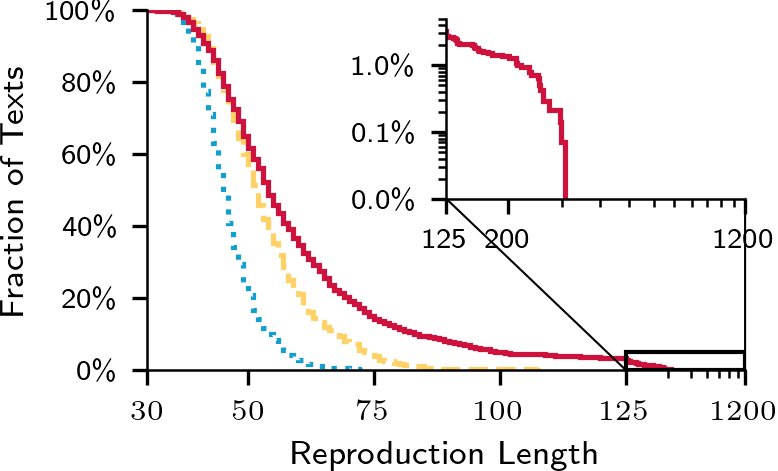

gpt-4-turbo-2024-04-09
creative 89
argumentative 174
expository 660


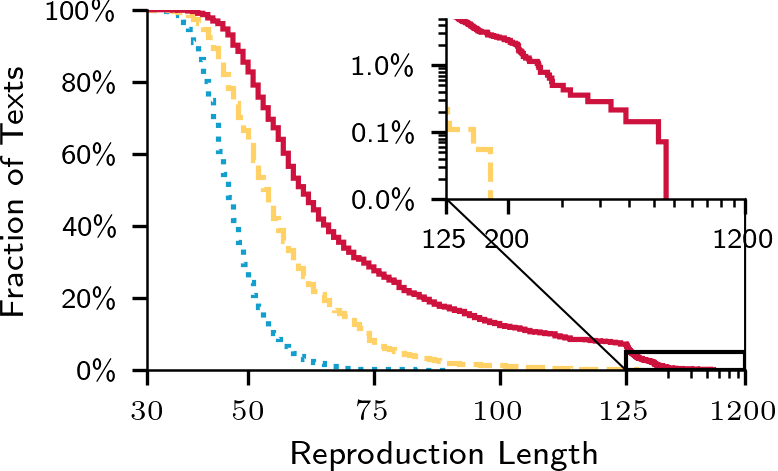

gpt-4o-2024-05-13
creative 86
argumentative 168
expository 246


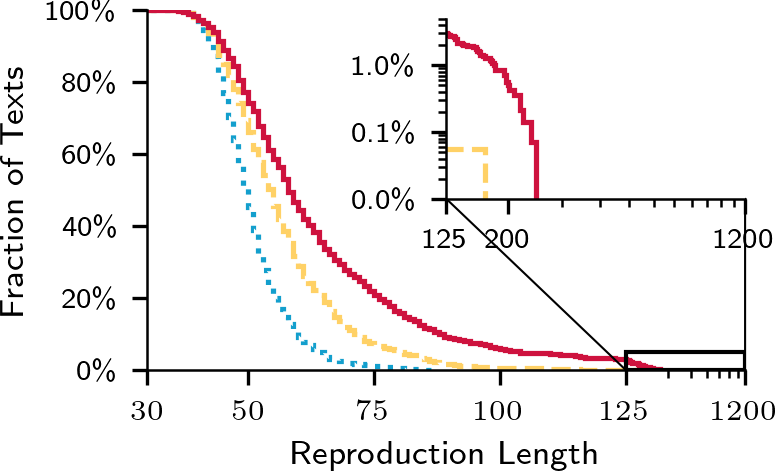

gpt-4o-mini-2024-07-18
creative 85
argumentative 119
expository 513


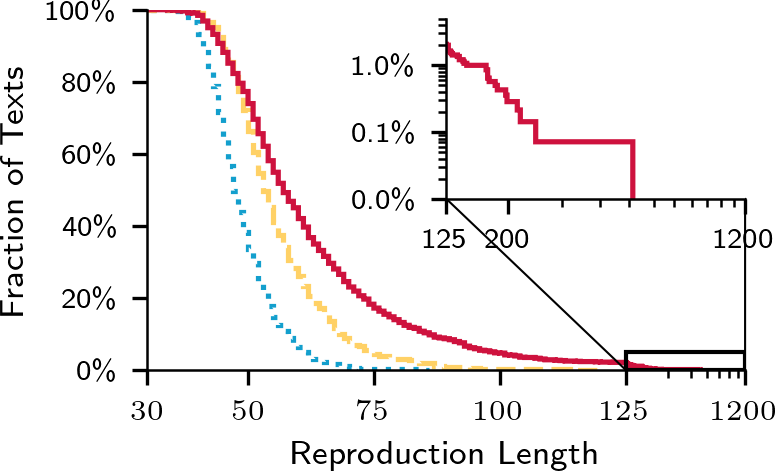

humans
creative 365
argumentative 2399
expository 958


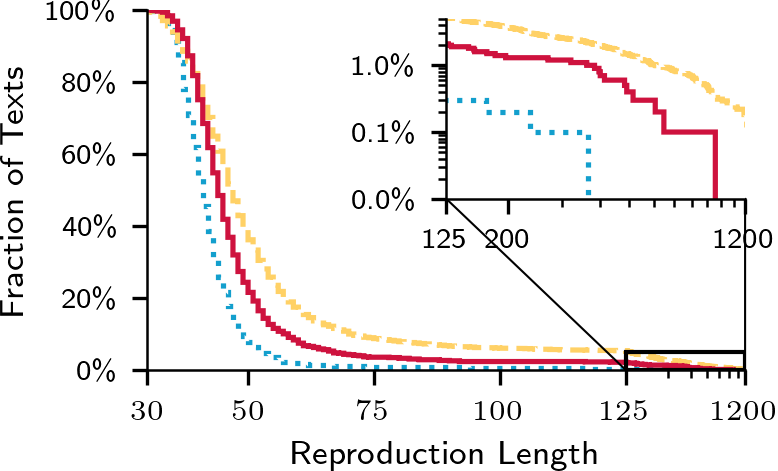

llama-3.1-405b-instruct
creative 136
argumentative 111
expository 699


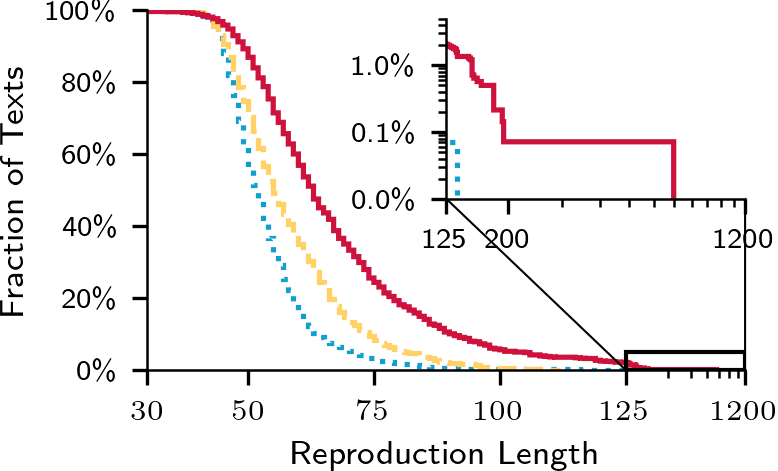

llama-3.1-70b-instruct
creative 123
argumentative 130
expository 219


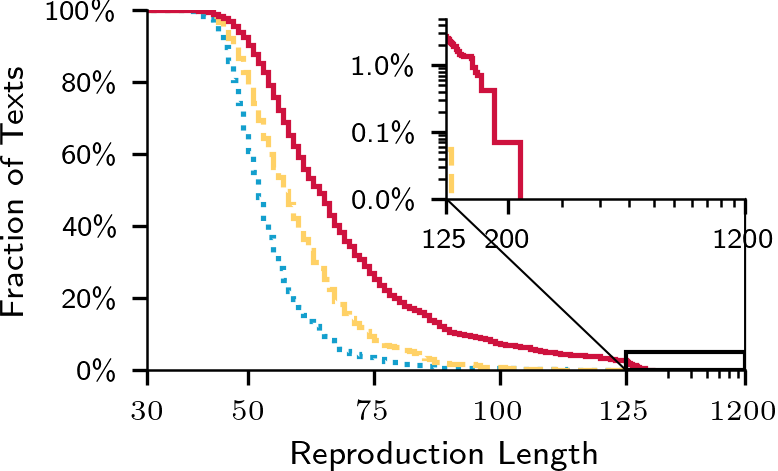

llama-3.1-8b-instruct
creative 136
argumentative 121
expository 189


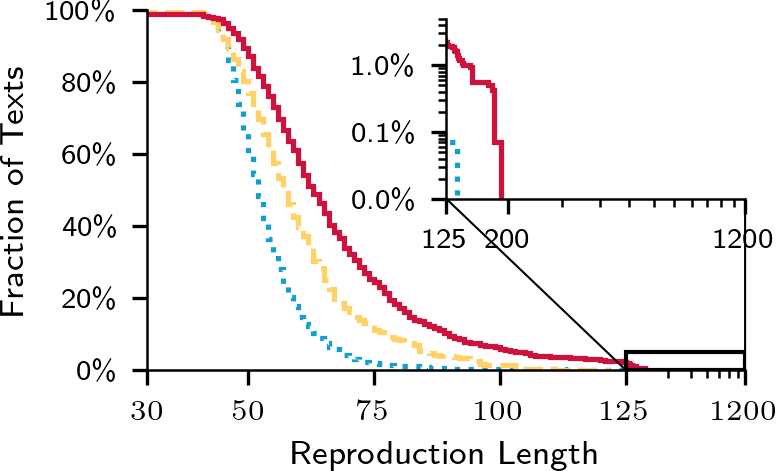

o1-mini-2024-09-12
creative 97
argumentative 115
expository 413


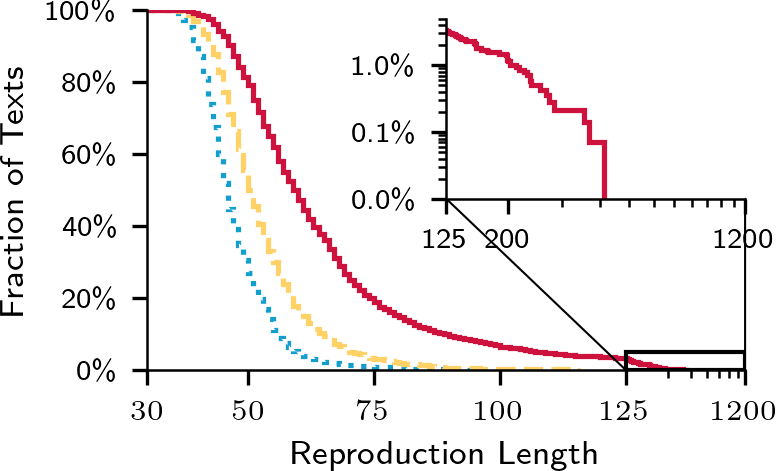

o1-preview-2024-09-12
creative 84
argumentative 131
expository 305


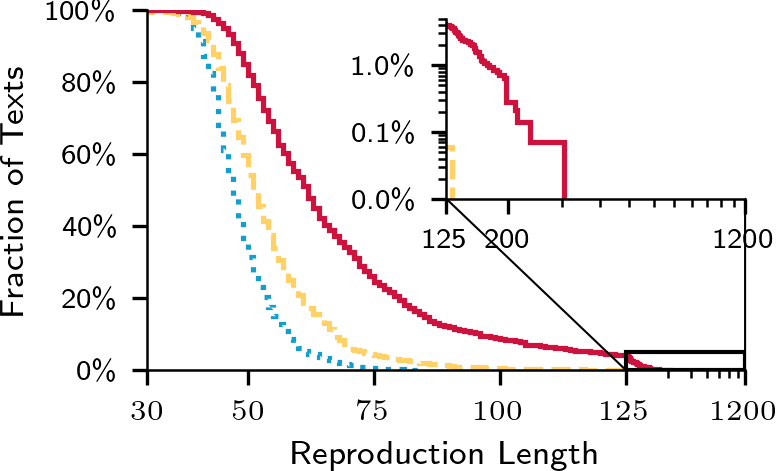

In [24]:
# Plot CDF of memorized fraction, sort-of
df_distributions_full = df_distributions.copy()

def calculate_chains_icdf(data: pd.DataFrame) -> np.ndarray:
    max_memorized = data["memorized_chars"].apply(max)
    max_memorized_counts = np.bincount(max_memorized)
    assert len(data) == np.sum(max_memorized_counts)
    max_memorized_cdf = np.cumsum(max_memorized_counts) / len(data)
    max_memorized_icdf = 1.0 - max_memorized_cdf
    return pd.Series({"max_memorized_icdf": max_memorized_icdf})

df_distributions_full = df_distributions_full.groupby(["model", "text_type"]).apply(calculate_chains_icdf, include_groups=False).reset_index()
df_distributions_full = df_distributions_full.set_index(["model", "text_type"])

for model in df_distributions_full.index.get_level_values("model").unique():

    print(model)
    df_plot = df_distributions_full.loc[model]

    fig, ax = plt.subplots(figsize=plot_util.FIGURE_SIZE_HALF_IN)

    for text_type in TEXT_TYPE_LABELS.keys():
        ax.stairs(
            values=df_plot.loc[text_type]["max_memorized_icdf"],
            fill=False,
            color=TEXT_TYPE_COLOR_MAP[text_type],
            label=TEXT_TYPE_LABELS[text_type],
            linestyle=TEXT_TYPE_LINESTYLE_MAP[text_type]
        )

    SCALE_MIN = 30
    SCALE_SPLIT = SCALE_SWITCH_VALUE
    SCALE_MAX = 1200
    SPLIT_FRACTION = 0.8

    # Custom x-axis scaling:
    # Do a linear scale from SCALE_MIN to SCALE_SPLIT and a log scale from SCALE_SPLIT to SCALE_MAX
    # Use SPLIT_FRACTION to determine the split (fraction of full [0,1] range that belongs to the linear part)
    def scale_func(x):
        with np.errstate(divide="ignore"):
            return np.where(
                x < SCALE_SPLIT,
                SPLIT_FRACTION * (x - SCALE_MIN) / (SCALE_SPLIT - SCALE_MIN),
                SPLIT_FRACTION + (1 - SPLIT_FRACTION) * np.log(x / SCALE_SPLIT) / np.log(SCALE_MAX / SCALE_SPLIT)
            )

    def scale_func_inv(x):
        return np.where(
            x < SPLIT_FRACTION,
            SCALE_MIN + (SCALE_SPLIT - SCALE_MIN) * x / SPLIT_FRACTION,
            SCALE_SPLIT * np.exp((x - SPLIT_FRACTION) * np.log(SCALE_MAX / SCALE_SPLIT) / (1 - SPLIT_FRACTION))
        )

    ax.set_xlim(SCALE_MIN, SCALE_MAX)
    ax.set_xscale(matplotlib.scale.FuncScale(axis=ax, functions=(scale_func, scale_func_inv)))
    ax.set_xticks((SCALE_MIN, MEMORIZATION_THRESHOLD, 75, 100, SCALE_SPLIT, SCALE_MAX), minor=False)
    ax.set_xlabel(DISTRIBUTION_XAXIS_LABEL)
    ax.set_xticks((np.linspace(SCALE_SPLIT, SCALE_MAX, num=8)), minor=True)

    ax.set_ylim(0, 1)
    ax.set_ylabel(DISTRIBUTION_YAXIS_LABEL)
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))

    # Inset axes for second part
    ax_ins = ax.inset_axes([0.5, 0.475, 0.5, 0.5])
    for text_type in TEXT_TYPE_LABELS.keys():
        ax_ins.stairs(
            values=df_plot.loc[text_type]["max_memorized_icdf"],
            fill=False,
            color=TEXT_TYPE_COLOR_MAP[text_type],
            linestyle=TEXT_TYPE_LINESTYLE_MAP[text_type]
        )
        print(text_type, np.argmax(df_plot.loc[text_type]["max_memorized_icdf"] == 0.0))
    ax_ins.set_xlim(SCALE_SPLIT, SCALE_MAX)
    ax_ins.set_ylim(0.0001, 0.05)
    ax_ins.loglog()
    ins_xticks = (SCALE_SPLIT, 200, SCALE_MAX)
    ax_ins.set_xticks(ins_xticks, minor=False)
    ax_ins.set_xticks(np.linspace(200, SCALE_MAX, num=11), minor=True)
    ax_ins.set_xticklabels(ins_xticks)
    ax_ins.set_xticklabels((), minor=True)
    ax_ins.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=1))

    rect, connects = ax.indicate_inset_zoom(ax_ins, edgecolor="black", lw=1.0, alpha=1.0)
    for idx, connect in enumerate(connects):
        connect.set_linewidth(0.5)
        connect.set_visible(idx % 2 == 0)

    plt.show()
    fig.savefig(PLOT_OUTPUT_DIR / f"distribution_all_{model}.pdf")

    plt.close(fig)



In [25]:
# model_groupings = (
#     ("humans",),
#     ("gpt-4o-mini-2024-07-18", "gpt-4o-2024-05-13", "gpt-4-turbo-2024-04-09",),
#     ("claude-3-haiku", "claude-3.5-sonnet", "claude-3-opus",),
#     ("llama-3.1-8b-instruct", "llama-3.1-70b-instruct", "llama-3.1-405b-instruct",),
#     ("gemini-1.5-flash-002", "gemini-1.5-pro-002",),
#     ("o1-mini-2024-09-12", "o1-preview-2024-09-12",),
# )

# for row in model_groupings:
#     print(r"\begin{subfigure}[t]{\figfull}")
#     print(r"\centering")
#     for idx, model in enumerate(row):
#         print(r"\begin{subfigure}[t]{\figthird}")
#         print(r"\centering")
#         print(rf"\includegraphics[width=\linewidth]{{distribution_all_{model}.pdf}}")
#         print(rf"\caption{{{MODEL_NAMES[model]}}}")
#         print(r"\end{subfigure}")
#         if idx < len(row) - 1 and len(row) == 3:
#             print(r"\hfill%")
#     print(r"\end{subfigure}")


## Human baselines

In [26]:
BASELINES = (
    "explainlikeimfive",
    "imdb_reviews",
    "writing_prompts",
)

current_models = (
    "humans",
    "gpt-4o-mini-2024-07-18", "gpt-4o-2024-05-13", "gpt-4-turbo-2024-04-09",
    "claude-3-haiku", "claude-3.5-sonnet", "claude-3-opus",
    "llama-3.1-8b-instruct" ,"llama-3.1-70b-instruct" ,"llama-3.1-405b-instruct",
    "gemini-1.5-flash-002", "gemini-1.5-pro-002",
    "o1-mini-2024-09-12", "o1-preview-2024-09-12",
)

selected_models = (
    "humans",
    "gpt-4o-mini-2024-07-18", "gpt-4o-2024-05-13", "gpt-4-turbo-2024-04-09",
    "claude-3-haiku", "claude-3.5-sonnet", "claude-3-opus",
    "llama-3.1-8b-instruct" ,"llama-3.1-70b-instruct" ,"llama-3.1-405b-instruct",
    "gemini-1.5-flash-002", "gemini-1.5-pro-002",
    # "o1-mini-2024-09-12", "o1-preview-2024-09-12",
)

current_data = []
for setting in tqdm.tqdm(BASELINES):
    for result_file in tuple((RESULTS_BASE_DIR / setting).glob("*.jsonl")):
        model, temperature_raw = result_file.stem.split("_")
        if model not in current_models:
            continue
        temperature = float(temperature_raw[len("temp"):]) if temperature_raw != "tempX.X" else None
        if temperature is not None and temperature != DEFAULT_TEMPERATURE and (model != "humans" and (not model.startswith("o1"))):
            continue
        with open(result_file, "r") as f:
            for line in f:
                raw_data = json.loads(line)
                if "error" in raw_data:
                    continue
                if is_refusal(raw_data["completion"]):
                    continue
                # Special case, drop old IMDB reviews
                if setting == "imdb_reviews" and model == "humans" and datetime.date.fromisoformat(raw_data["review_date"]) < IMDB_REVIEW_DATE_MIN:
                    continue
                memorized_chars = np.array(raw_data["memorized_chars"])
                memorized_fraction = np.mean(memorized_chars >= MEMORIZATION_THRESHOLD)
                completion_length = len(raw_data["completion"])
                current_data.append({
                    "model": model,
                    "type": raw_data["type"],
                    "memorized_fraction": memorized_fraction,
                    "memorized_chars": memorized_chars,
                    "temperature": temperature,
                    "text_type": raw_data["text_type"],
                    "completion_length": completion_length,
                })

df_humans_raw = pd.DataFrame(current_data)
del current_data

100%|██████████| 3/3 [00:43<00:00, 14.53s/it]


### Distributions per baseline

In [27]:
# Plot (inverse) CDF of chains, sort-of

df_humans = df_humans_raw.copy()

df_humans = df_humans[df_humans["model"].isin(selected_models)]

df_humans.loc[:, "max_memorized"] = df_humans["memorized_chars"].apply(max)
total_max_memorized = df_humans["max_memorized"].max()

# Want the following array (for every model and temperature):
# index: longest chain
# value: fraction of submissions with chain length >= index

def calculate_chains_icdf(data: pd.DataFrame) -> np.ndarray:
    max_memorized_counts = np.bincount(data["max_memorized"], minlength=total_max_memorized + 1)
    assert len(max_memorized_counts) == total_max_memorized + 1
    assert len(data) == np.sum(max_memorized_counts)
    max_memorized_cdf = np.cumsum(max_memorized_counts) / len(data)
    max_memorized_icdf = 1.0 - max_memorized_cdf
    return pd.Series({"max_memorized_icdf": max_memorized_icdf})

df_humans = df_humans.groupby(["type", "model"]).apply(calculate_chains_icdf, include_groups=False).reset_index()

def _calculate_bounds(data: pd.DataFrame) -> pd.Series:
    # data is grouped by type and model
    # At every point of the CDF, calculate the min and max over all models
    max_memorized_icdf = np.stack(data["max_memorized_icdf"].values)
    min_max_memorized_icdf = np.min(max_memorized_icdf, axis=0)
    max_max_memorized_icdf = np.max(max_memorized_icdf, axis=0)
    return pd.Series({
        "min_max_memorized_icdf": min_max_memorized_icdf,
        "max_max_memorized_icdf": max_max_memorized_icdf,
    })

df_humans_bounds = df_humans[df_humans["model"] != "humans"].groupby(["type"]).apply(_calculate_bounds, include_groups=False).reset_index()
df_humans_bounds = df_humans_bounds.set_index("type")

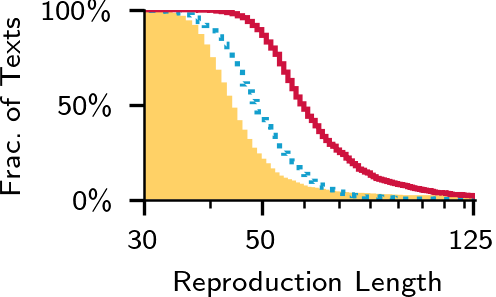

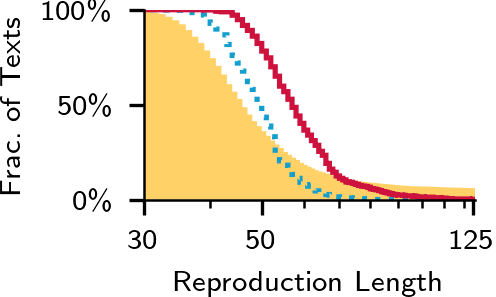

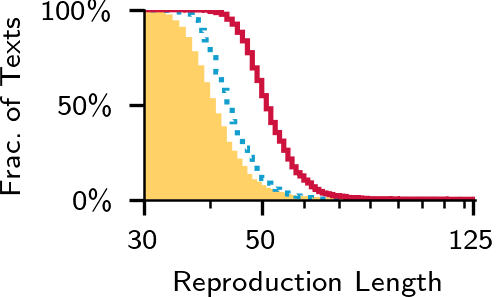

<Figure size 1647.88x58.1154 with 0 Axes>

In [28]:
MIN_LENGTH = 30
MAX_LENGTH = SCALE_SWITCH_VALUE

BOUND_LINESTYLE_MAP = {
    "lower": "dotted",
    "upper": "solid",
}

BASELINE_TITLES_KEYS = {
    "explainlikeimfive": ("Expository (ELI5)", "expository"),
    "imdb_reviews": ("Argumentative (IMDb)", "argumentative"),
    "writing_prompts": ("Creative (WritingPrompts)", "creative"),
}

legend_handles, legend_labels = None, None
for idx, baseline in enumerate(BASELINES):
    fig, ax = plt.subplots(figsize=plot_util.FIGURE_SIZE_THIRD_IN)
    title, key = BASELINE_TITLES_KEYS[baseline]

    df_humans_human, = df_humans[
        (df_humans["model"] == "humans") & (df_humans["type"] == baseline)
    ]["max_memorized_icdf"].values
    ax.stairs(df_humans_human, fill=True, color="C1", label="Humans")

    ax.stairs(
        df_humans_bounds.loc[baseline]["min_max_memorized_icdf"],
        fill=False,
        color="C0",
        linestyle=BOUND_LINESTYLE_MAP["lower"],
        label=r"Min.\ Over LLMs",
    )
    ax.stairs(
        df_humans_bounds.loc[baseline]["max_max_memorized_icdf"],
        fill=False,
        color="C2",
        linestyle=BOUND_LINESTYLE_MAP["upper"],
        label=r"Max.\ Over LLMs",
    )

    ax.semilogx()
    ax.set_xlim(MIN_LENGTH, MAX_LENGTH + 1)
    ax.set_xlabel(DISTRIBUTION_XAXIS_LABEL, fontsize=matplotlib.rcParams["axes.labelsize"] - 1)
    ax.set_ylabel(DISTRIBUTION_YAXIS_LABEL_SHORT, fontsize=matplotlib.rcParams["axes.labelsize"] - 1)
    ax.set_xticks((MIN_LENGTH, MEMORIZATION_THRESHOLD, MAX_LENGTH), minor=False)
    ax.set_xticks(np.linspace(MIN_LENGTH, MAX_LENGTH - (MAX_LENGTH % 10), num=(MAX_LENGTH - MIN_LENGTH) // 10 + 1), minor=True)
    ax.set_xticklabels((MIN_LENGTH, MEMORIZATION_THRESHOLD, MAX_LENGTH))
    ax.set_xticklabels((), minor=True)
    # Set y-axis to percentage
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))
    ax.set_ylim(0, 1)

    plt.show()
    fig.savefig(PLOT_OUTPUT_DIR / f"humans_{key}.pdf")
    legend_handles, legend_labels = ax.get_legend_handles_labels()
    plt.close(fig)

fig_legend = plt.figure(figsize=(plot_util.FIGURE_SIZE_FULL_IN[0], 14.0 / plot_util.TEX_PT_PER_IN))
fig_legend.legend(legend_handles, legend_labels, loc="center", ncol=3)
plt.show()
fig_legend.savefig(PLOT_OUTPUT_DIR / "humans_legend.pdf")
plt.close(fig_legend)



### Memorized fraction

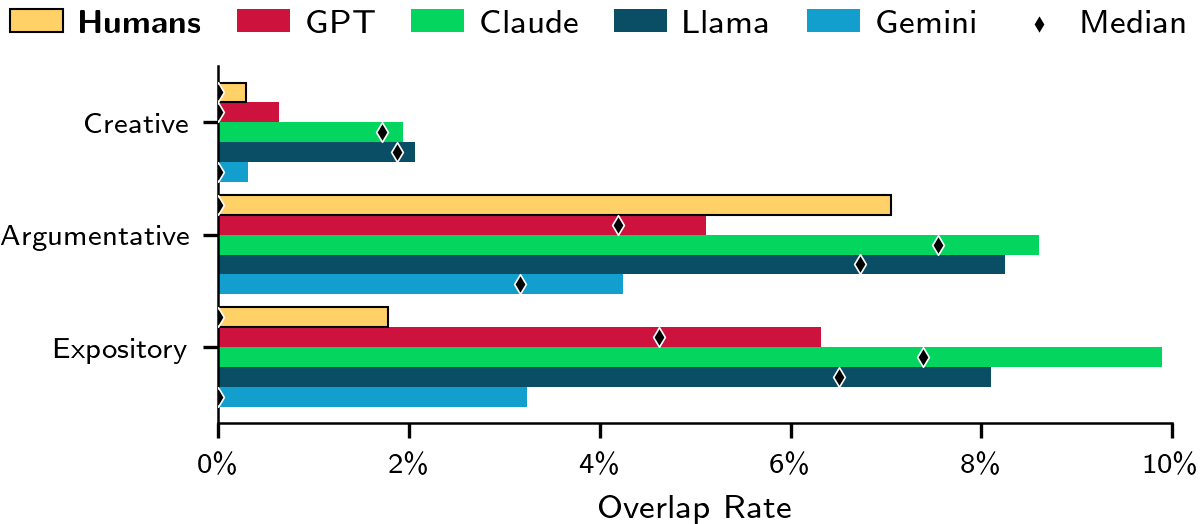

In [29]:
df_plot = df_humans_raw.copy()
df_plot = df_plot[df_plot["model"].isin(selected_models)]


# Merge models over families
MODEL_MERGE_MAP = {
    "gpt-4o-mini-2024-07-18": "gpt",
    "gpt-4o-2024-05-13": "gpt",
    "gpt-4-turbo-2024-04-09": "gpt",
    "claude-3-haiku": "claude",
    "claude-3.5-sonnet": "claude",
    "claude-3-opus": "claude",
    "llama-3.1-8b-instruct": "llama",
    "llama-3.1-70b-instruct": "llama",
    "llama-3.1-405b-instruct": "llama",
    "gemini-1.5-flash-002": "gemini",
    "gemini-1.5-pro-002": "gemini",
    # "o1-mini-2024-09-12": "o1",
    # "o1-preview-2024-09-12": "o1",
}
FAMILY_LABELS = {
    "humans": MODEL_NAMES["humans"],
    "gpt": "GPT",
    "claude": "Claude",
    "llama": "Llama",
    "gemini": "Gemini",
}
FAMILY_COLORS = {
    "humans": "C1",
    "gpt": "C2",
    "claude": "C4",
    "llama": "C3",
    "gemini": "C5",
}
FAMILY_HATCHES = {
    "humans": "",
    "gpt": "",
    "claude": "",
    "llama": "",
    "gemini": "",
}
FAMILY_EDGECOLORS = {
    "humans": "black",
    "gpt": None,
    "claude": None,
    "llama": None,
    "gemini": None,
}
TEXT_TYPE_ORDER = {key: idx for idx, key in enumerate(TEXT_TYPE_LABELS.keys())}

df_plot["model"] = df_plot["model"].replace(MODEL_MERGE_MAP)
df_plot = df_plot.groupby(["type", "model"]).agg({"memorized_fraction": ("mean", "median")}).droplevel(0, axis=1).unstack()
df_plot = df_plot.reindex(sorted(df_plot.index, key=lambda x: TEXT_TYPE_ORDER[TYPE_TEXT_TYPE_MAP[x]], reverse=True))

fig, ax = plt.subplots(figsize=plot_util.FIGURE_SIZE_NINE_COL_IN)

bar_size = plot_util.BAR_WIDTH / (4 - 0.5)
y_ticks_base = np.arange(len(df_plot))
for idx, model_key in enumerate(FAMILY_LABELS.keys()):
    bars = ax.barh(
        y_ticks_base - idx * bar_size + 1.5 * bar_size ,
        df_plot["mean"][model_key],
        color=FAMILY_COLORS[model_key],
        label=FAMILY_LABELS[model_key],
        hatch=FAMILY_HATCHES[model_key],
        height=bar_size,
        edgecolor=FAMILY_EDGECOLORS[model_key],
        linewidth=0.5,
        zorder=5 if model_key == "humans" else None,
    )

    # Add median
    for bar_idx, bar in enumerate(bars):
        # ax.vlines(df_plot["median"][model_key].iloc[bar_idx], ymin=bar.get_y(), ymax=bar.get_y() + bar.get_height(), color="black")
        # Actually, add a marker instead
        median_dot = ax.scatter(
            df_plot["median"][model_key].iloc[bar_idx],
            bar.get_y() + bar.get_height() / 2,
            marker="d",
            color="black",
            edgecolor="white",
            zorder=10,
            s=11,
            lw=0.4,
            # lw=1.0,
        )

ax.set_xlabel(FRACTION_XAXIS_LABEL_MEANMEDIAN)
ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylabel(None)
# Reduce y-axis font size a bit (get font size from rcParams)
ax.set_yticks(y_ticks_base)
ax.set_yticklabels([TEXT_TYPE_LABELS[TYPE_TEXT_TYPE_MAP[type_key]] for type_key in df_plot.index])
ax.set_xlim(0, 0.10)

legend_handles, legend_labels = ax.get_legend_handles_labels()
legend_labels[0] = rf"\textbf{{{legend_labels[0]}}}"
legend_handles.append(median_dot)
legend_labels.append("Median")

fig.legend(legend_handles, legend_labels, ncol=6, loc="outside upper center")
plot_util.resize_figure_with_legend(fig)

plt.show()
fig.savefig(PLOT_OUTPUT_DIR / "humans_fraction.pdf")

plt.close(fig)


In [30]:
df_plot

mean                                            median  \
model                claude    gemini       gpt    humans     llama    claude   
type                                                                            
explainlikeimfive  0.098913  0.032371  0.063145  0.017739  0.080950  0.073829   
imdb_reviews       0.086013  0.042374  0.051078  0.070478  0.082510  0.075477   
writing_prompts    0.019394  0.003067  0.006352  0.002890  0.020663  0.017177   

                                                        
model                gemini       gpt humans     llama  
type                                                    
explainlikeimfive  0.000000  0.046189    0.0  0.065103  
imdb_reviews       0.031669  0.041849    0.0  0.067308  
writing_prompts    0.000000  0.000000    0.0  0.018684

### Memorized fraction per baseline (appendix)

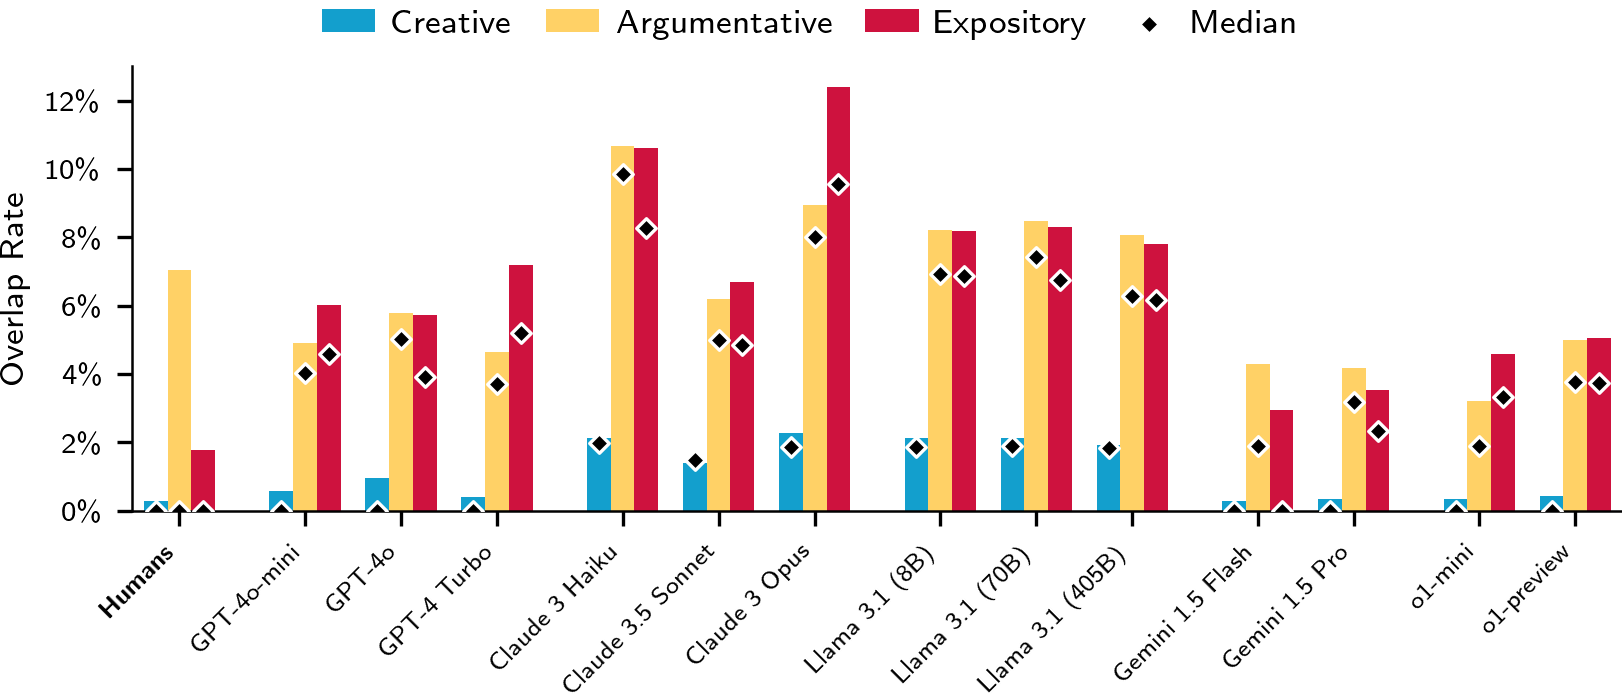

In [31]:
df_plot = df_humans_raw.copy()
df_plot = df_humans_raw.groupby(["model", "type"]).agg({"memorized_fraction": ("mean", "median")}).droplevel(0, axis=1).unstack()
df_plot = df_plot.reindex(sorted(df_plot.index, key=lambda x: MODEL_ORDER[x], reverse=False))

TASK_ORDER = ("writing_prompts", "imdb_reviews", "explainlikeimfive")

fig, ax = plt.subplots(figsize=(plot_util.FIGURE_SIZE_FULL_IN[0], plot_util.FIGURE_SIZE_FULL_IN[0] / plot_util.SILVER_RATIO))

bar_size = plot_util.BAR_WIDTH / (3 - 0.5)
bar_gap = (1.0 - plot_util.BAR_WIDTH) * 0.8
bar_space_at = (1,4,7,10,12)
x_ticks_base = np.arange(len(df_plot), dtype=float)
for bar_space_idx in bar_space_at:
    x_ticks_base[bar_space_idx:] += bar_gap
for idx, task_type in enumerate(TASK_ORDER):
    bars = ax.bar(
        x_ticks_base - (len(TASK_ORDER) - 1 - idx) * bar_size + bar_size,
        df_plot["mean"][task_type],
        color=f"C{idx}",
        label=f"{TEXT_TYPE_LABELS[TYPE_TEXT_TYPE_MAP[task_type]]}",
        width=bar_size,
    )

    # Add median
    for bar_idx, bar in enumerate(bars):
        # ax.hlines(df_plot["median"][task_type].iloc[bar_idx], xmin=bar.get_x(), xmax=bar.get_x() + bar.get_width(), color="black")
        median_dot = ax.scatter(
            bar.get_x() + bar.get_width() / 2,
            df_plot["median"][task_type].iloc[bar_idx],
            marker="D",
            color="black",
            edgecolor="white",
            zorder=10,
            s=11,
            lw=0.8,
        )

ax.set_ylabel(FRACTION_XAXIS_LABEL_MEANMEDIAN)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_xlabel(None)
ax.set_xlim(x_ticks_base[0] - (len(TASK_ORDER) - 1) * bar_size, x_ticks_base[-1] + (len(TASK_ORDER) - 1) * bar_size)
ax.set_xticks(x_ticks_base)
ax.set_xticklabels(
    [MODEL_NAMES[model] if model != "humans" else rf"\textbf{{{MODEL_NAMES[model]}}}" for model in df_plot.index],
    fontsize=matplotlib.rcParams["xtick.labelsize"] - 1,
    rotation=45,
    ha="right",
)
ax.set_ylim(0, 0.13)

legend_handles, legend_labels = ax.get_legend_handles_labels()
legend_handles.append(median_dot)
legend_labels.append("Median")

fig.legend(legend_handles, legend_labels, ncol=4, loc="outside upper center")
plot_util.resize_figure_with_legend(fig)

plt.show()
fig.savefig(PLOT_OUTPUT_DIR / "humans_fraction_aux.pdf")

plt.close(fig)


In [32]:
df_plot

mean                               \
type                    explainlikeimfive imdb_reviews writing_prompts   
model                                                                    
humans                           0.017739     0.070478        0.002890   
gpt-4o-mini-2024-07-18           0.060311     0.049077        0.005700   
gpt-4o-2024-05-13                0.057311     0.057802        0.009512   
gpt-4-turbo-2024-04-09           0.071813     0.046354        0.003842   
claude-3-haiku                   0.106069     0.106785        0.021310   
claude-3.5-sonnet                0.066844     0.061828        0.014064   
claude-3-opus                    0.123970     0.089460        0.022815   
llama-3.1-8b-instruct            0.081859     0.082115        0.021305   
llama-3.1-70b-instruct           0.083026     0.084771        0.021375   
llama-3.1-405b-instruct          0.077964     0.080640        0.019310   
gemini-1.5-flash-002             0.029312     0.042999        0.002770   
gemini-1.5-pro-002               0.035431     0.041748        0.003365   
o1-mini-2024-09-12               0.045877     0.031990        0.003515   
o1-preview-2024-09-12            0.050545     0.049865        0.004316   

                                   median                               
type                    explainlikeimfive imdb_reviews writing_prompts  
model                                                                   
humans                           0.000000     0.000000        0.000000  
gpt-4o-mini-2024-07-18           0.045889     0.040382        0.000000  
gpt-4o-2024-05-13                0.039165     0.050322        0.000000  
gpt-4-turbo-2024-04-09           0.051841     0.036938        0.000000  
claude-3-haiku                   0.082566     0.098431        0.019658  
claude-3.5-sonnet                0.048559     0.050063        0.014935  
claude-3-opus                    0.095705     0.079977        0.018605  
llama-3.1-8b-instruct            0.068534     0.069325        0.018710  
llama-3.1-70b-instruct           0.067404     0.074129        0.018883  
llama-3.1-405b-instruct          0.061629     0.062930        0.018259  
gemini-1.5-flash-002             0.000000     0.018974        0.000000  
gemini-1.5-pro-002               0.023423     0.031669        0.000000  
o1-mini-2024-09-12               0.033228     0.018872        0.000000  
o1-preview-2024-09-12            0.037469     0.037645        0.000000

## Mitigation strategies

In [33]:
current_settings = (
    "ablation_assistant",
    "ablation_simple",
    "general_prompts",
    "essay_persuade",
)

current_models = (
    # "humans",
    "gpt-4o-mini-2024-07-18", "gpt-4o-2024-05-13", "gpt-4-turbo-2024-04-09",
    "claude-3-haiku", "claude-3.5-sonnet", "claude-3-opus",
    "llama-3.1-8b-instruct" ,"llama-3.1-70b-instruct" ,"llama-3.1-405b-instruct",
    "gemini-1.5-flash-002", "gemini-1.5-pro-002",
    # "o1-mini-2024-09-12", "o1-preview-2024-09-12",
)
subset_models = (
    "gpt-4o-mini-2024-07-18", "gpt-4o-2024-05-13",
    "claude-3-haiku", "claude-3.5-sonnet", "claude-3-opus",
    "llama-3.1-8b-instruct", "llama-3.1-405b-instruct",
    "gemini-1.5-flash-002", "gemini-1.5-pro-002",
    # "o1-mini-2024-09-12", "o1-preview-2024-09-12",
)

current_data = []
for setting in tqdm.tqdm(current_settings):
    for result_file in tuple((RESULTS_BASE_DIR / setting).glob("*.jsonl")):
        model, temperature_raw = result_file.stem.split("_")
        temperature = float(temperature_raw[len("temp"):]) if temperature_raw != "tempX.X" else None
        if model not in current_models:
            continue
        if temperature is not None and temperature != DEFAULT_TEMPERATURE:
            continue
        with open(result_file, "r") as f:
            for line in f:
                raw_data = json.loads(line)
                if "error" in raw_data:
                    continue
                if is_refusal(raw_data["completion"]):
                    continue
                memorized_chars = np.array(raw_data["memorized_chars"])
                memorized_fraction = np.mean(memorized_chars >= MEMORIZATION_THRESHOLD)
                current_data.append({
                    "model": model,
                    "type": raw_data["type"],
                    "memorized_fraction": memorized_fraction,
                    "memorized_chars": memorized_chars,
                    "text_type": raw_data["text_type"],
                    "ablation": raw_data.get("ablation", "original"),
                })

df_mitigation = pd.DataFrame(current_data)
del current_data


100%|██████████| 4/4 [00:13<00:00,  3.30s/it]


### Average change

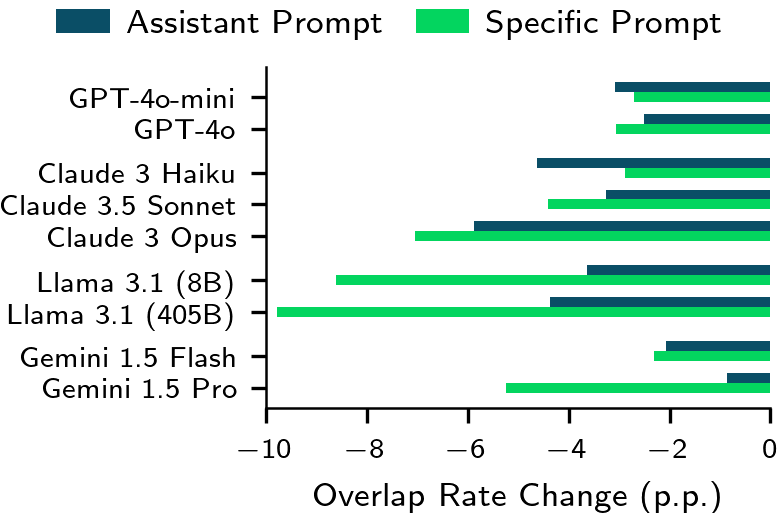

In [34]:
df_mitigation_subset = df_mitigation[df_mitigation["model"].isin(subset_models)]
df_mitigation_average = df_mitigation_subset.groupby(["model", "ablation"]).agg({"memorized_fraction": "mean"}).unstack().droplevel(0, axis=1)

df_mitigation_average["assistant"] = df_mitigation_average["assistant"] - df_mitigation_average["original"]
df_mitigation_average["simple"] = df_mitigation_average["simple"] - df_mitigation_average["original"]
df_mitigation_average = df_mitigation_average.drop(columns="original")

STRATEGY_NAMES = {
    "assistant": "Assistant Prompt",
    "simple": "Specific Prompt",
    "original": "Original",
}

COLOR_MAP = {
    "original": "C0",
    "assistant": "C3",
    "simple": "C4",
}
LINESTYLE_MAP = {
    "original": "dotted",
    "assistant": "dashed",
    "simple": "solid",
}

df_mitigation_average = df_mitigation_average.reindex(sorted(df_mitigation_average.index, key=lambda x: MODEL_ORDER[x], reverse=True))

fig, ax = plt.subplots(figsize=plot_util.FIGURE_SIZE_HALF_IN)

bar_size = plot_util.BAR_WIDTH / (2)
bar_gap = 1.0 - plot_util.BAR_WIDTH
bar_space_at = (2, 4, 7)
y_ticks_base = np.arange(len(df_mitigation_average), dtype=float)
for bar_space_idx in bar_space_at:
    y_ticks_base[bar_space_idx:] += bar_gap
for idx, ablation_type in enumerate(df_mitigation_average.columns):
    bars = ax.barh(
        y_ticks_base - idx * bar_size + bar_size,
        df_mitigation_average[ablation_type],
        color=COLOR_MAP[ablation_type],
        label=STRATEGY_NAMES[ablation_type],
        height=bar_size,
    )

ax.set_xlabel(FRACTION_XAXIS_LABEL_CHANGE)
ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0, symbol=""))
ax.set_yticks(y_ticks_base)
ax.set_yticklabels(
    [MODEL_NAMES[model] for model in df_mitigation_average.index],
    rotation=0,
    ha="right"
)
ax.set_ylabel(None)
ax.set_xlim(-0.1, 0)

legend_handles, legend_labels = ax.get_legend_handles_labels()
fig.legend(legend_handles, legend_labels, loc="outside upper center", ncol=2)
plot_util.resize_figure_with_legend(fig)

plt.show()
fig.savefig(PLOT_OUTPUT_DIR / "mitigation_average.pdf")
plt.close(fig)

In [35]:
df_mitigation.groupby(["model", "ablation"]).agg({"memorized_fraction": "mean"}).unstack().droplevel(0, axis=1)

ablation,assistant,original,simple
model,,,
claude-3-haiku,0.095628,0.141927,0.113036
claude-3-opus,0.126388,0.185143,0.114628
claude-3.5-sonnet,0.088373,0.121036,0.076907
gemini-1.5-flash-002,0.051898,0.072618,0.049612
gemini-1.5-pro-002,0.078007,0.086700,0.034298
gpt-4-turbo-2024-04-09,0.070826,0.097184,0.069428
gpt-4o-2024-05-13,0.092120,0.117196,0.086483
gpt-4o-mini-2024-07-18,0.069824,0.100624,0.073648
llama-3.1-405b-instruct,0.115338,0.158990,0.061156


### Distribution

In [36]:
# Plot (inverse) CDF of chains, sort-of

df_mitigation_distribution = df_mitigation.copy()

df_mitigation_distribution.loc[:, "max_memorized"] = df_mitigation_distribution["memorized_chars"].apply(max)

# Want the following array (for every model and temperature):
# index: longest chain
# value: fraction of submissions with chain length >= index

def calculate_chains_icdf(data: pd.DataFrame) -> np.ndarray:
    max_memorized_counts = np.bincount(data["max_memorized"])
    assert len(data) == np.sum(max_memorized_counts)
    max_memorized_cdf = np.cumsum(max_memorized_counts) / len(data)
    max_memorized_icdf = 1.0 - max_memorized_cdf
    return pd.Series({"max_memorized_icdf": max_memorized_icdf})

df_mitigation_distribution = df_mitigation_distribution.groupby(["ablation"]).apply(calculate_chains_icdf, include_groups=False).reset_index()
df_mitigation_distribution = df_mitigation_distribution.set_index("ablation")

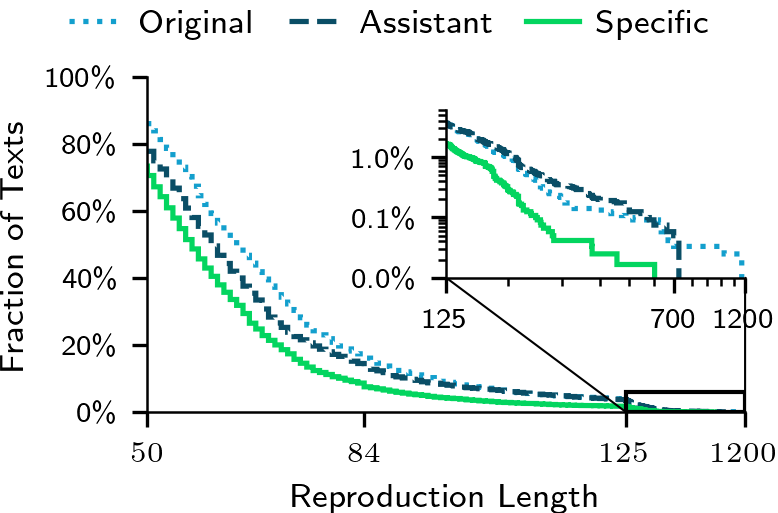

In [37]:

fig, ax = plt.subplots(figsize=plot_util.FIGURE_SIZE_HALF_IN)

ax.stairs(df_mitigation_distribution.loc["original"].values[0], fill=False, color=COLOR_MAP["original"], label=STRATEGY_NAMES["original"], linestyle=LINESTYLE_MAP["original"])
ax.stairs(df_mitigation_distribution.loc["assistant"].values[0], fill=False, color=COLOR_MAP["assistant"], label=STRATEGY_NAMES["assistant"][:-len(" Prompt")], linestyle=LINESTYLE_MAP["assistant"])
ax.stairs(df_mitigation_distribution.loc["simple"].values[0], fill=False, color=COLOR_MAP["simple"], label=STRATEGY_NAMES["simple"][:-len(" Prompt")], linestyle=LINESTYLE_MAP["simple"])

ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))

SCALE_MIN = 50
SCALE_SPLIT = SCALE_SWITCH_VALUE
SCALE_MAX = 1200
SPLIT_FRACTION = 0.8

# Custom x-axis scaling:
# Do a linear scale from SCALE_MIN to SCALE_SPLIT and a log scale from SCALE_SPLIT to SCALE_MAX
# Use SPLIT_FRACTION to determine the split (fraction of full [0,1] range that belongs to the linear part)
def scale_func(x):
    with np.errstate(divide="ignore"):
        return np.where(
            x < SCALE_SPLIT,
            SPLIT_FRACTION * (x - SCALE_MIN) / (SCALE_SPLIT - SCALE_MIN),
            SPLIT_FRACTION + (1 - SPLIT_FRACTION) * np.log(x / SCALE_SPLIT) / np.log(SCALE_MAX / SCALE_SPLIT)
        )

def scale_func_inv(x):
    return np.where(
        x < SPLIT_FRACTION,
        SCALE_MIN + (SCALE_SPLIT - SCALE_MIN) * x / SPLIT_FRACTION,
        SCALE_SPLIT * np.exp((x - SPLIT_FRACTION) * np.log(SCALE_MAX / SCALE_SPLIT) / (1 - SPLIT_FRACTION))
    )

ax.set_xlim(SCALE_MIN, SCALE_MAX)
ax.set_xscale(matplotlib.scale.FuncScale(axis=ax, functions=(scale_func, scale_func_inv)))
ax.set_xticks((SCALE_MIN, 84, SCALE_SPLIT, SCALE_MAX), minor=False)
ax.set_xticklabels((), minor=True)

ax.set_xlabel(DISTRIBUTION_XAXIS_LABEL)

ax.set_ylim(0, 1)
ax.set_ylabel(DISTRIBUTION_YAXIS_LABEL)

# Inset axes for second part
ax_ins = ax.inset_axes([0.5, 0.4, 0.5, 0.5])
ax_ins.stairs(df_mitigation_distribution.loc["original"].values[0], fill=False, color=COLOR_MAP["original"], linestyle=LINESTYLE_MAP["original"])
ax_ins.stairs(df_mitigation_distribution.loc["assistant"].values[0], fill=False, color=COLOR_MAP["assistant"], linestyle=LINESTYLE_MAP["assistant"])
ax_ins.stairs(df_mitigation_distribution.loc["simple"].values[0], fill=False, color=COLOR_MAP["simple"], linestyle=LINESTYLE_MAP["simple"])
ax_ins.set_xlim(SCALE_SPLIT, SCALE_MAX)
ax_ins.set_ylim(0.0001, 0.06)
ax_ins.loglog()
ins_xticks = (SCALE_SPLIT, 700, SCALE_MAX)
ax_ins.set_xticks(ins_xticks, minor=False)
ax_ins.set_xticks(np.linspace(200, 1200, num=11), minor=True)
ax_ins.set_xticklabels(ins_xticks)
ax_ins.set_xticklabels((), minor=True)
ax_ins.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=1))

rect, connects = ax.indicate_inset_zoom(ax_ins, edgecolor="black", lw=1.0, alpha=1.0)
for idx, connect in enumerate(connects):
    connect.set_linewidth(0.5)
    connect.set_visible(idx % 2 == 0)

legend_handles, legend_labels = ax.get_legend_handles_labels()
fig.legend(legend_handles, legend_labels, loc="outside upper center", ncol=4)
plot_util.resize_figure_with_legend(fig)

plt.show()
fig.savefig(PLOT_OUTPUT_DIR / f"mitigation_distribution.pdf")

plt.close(fig)


# Appendix/aux

## Temperature comparison

In [38]:
current_models = (
    # "humans",
    "gpt-4o-mini-2024-07-18", "gpt-4o-2024-05-13", "gpt-4-turbo-2024-04-09",
    "claude-3-haiku", "claude-3.5-sonnet", "claude-3-opus",
    "llama-3.1-8b-instruct" ,"llama-3.1-70b-instruct" ,"llama-3.1-405b-instruct",
    "gemini-1.5-flash-002", "gemini-1.5-pro-002",
)
current_ignored_settings = (
    # "ablation_assistant",
    # "ablation_simple",
)

current_data = []
for setting in tqdm.tqdm(RESULTS_DIRS):
    if setting in current_ignored_settings:
        continue
    for result_file in tuple((RESULTS_BASE_DIR / setting).glob("*.jsonl")):
        model, temperature_raw = result_file.stem.split("_")
        temperature = temperature_raw[len("temp"):] if temperature_raw != "tempX.X" else None
        assert temperature is not None
        if model not in current_models:
            continue
        with open(result_file, "r") as f:
            for line in f:
                raw_data = json.loads(line)
                if "error" in raw_data:
                    continue
                if is_refusal(raw_data["completion"]):
                    continue
                # Special case, drop old IMDB reviews
                if setting == "imdb_reviews" and model == "humans" and datetime.date.fromisoformat(raw_data["review_date"]) < IMDB_REVIEW_DATE_MIN:
                    continue
                memorized_chars = np.array(raw_data["memorized_chars"])
                memorized_fraction = np.mean(memorized_chars >= MEMORIZATION_THRESHOLD)
                max_memorized = np.max(memorized_chars)
                ablation = raw_data.get("ablation", "original")
                current_data.append({
                    "model": model,
                    "type": raw_data["type"],
                    "memorized_fraction": memorized_fraction,
                    "max_memorized": max_memorized,
                    "text_type": raw_data["text_type"],
                    "temperature": temperature,
                    "ablation": ablation,
                })

df_temperature = pd.DataFrame(current_data)
del current_data

100%|██████████| 8/8 [00:33<00:00,  4.22s/it]


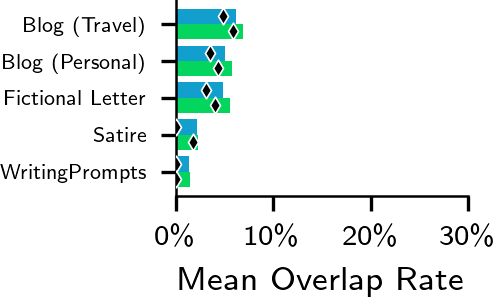

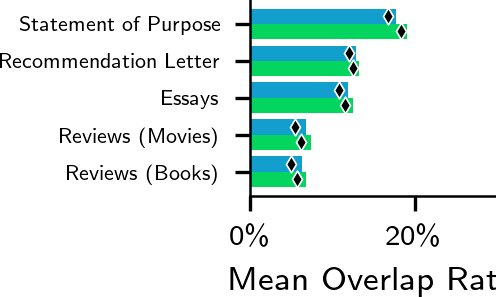

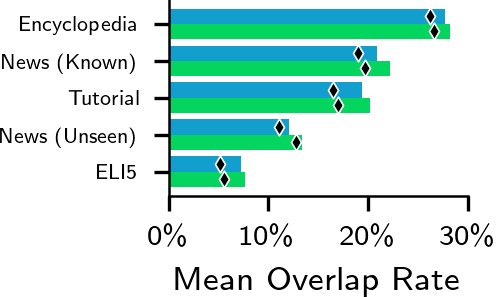

<Figure size 1647.88x58.1154 with 0 Axes>

In [39]:
for text_type in TEXT_TYPE_LABELS.keys():
    df_plot = df_temperature[df_temperature["text_type"] == text_type]
    # FIXME: also do ablations?
    df_plot = df_plot[df_plot["ablation"] == "original"]
    df_plot = df_plot.groupby(["temperature", "type"]).agg({"memorized_fraction": ("mean", "median")}).droplevel(0, axis=1)

    # Use ordering at default temperature
    index_order = df_plot.loc[str(DEFAULT_TEMPERATURE)].sort_values("mean", ascending=True).index

    fig, ax = plt.subplots(figsize=plot_util.FIGURE_SIZE_THIRD_IN)

    bar_size = plot_util.BAR_WIDTH / (2 - 0.5)
    legend_suffixes = [
        "(Our Default)",
        "(Greedy Decoding)",
    ]

    temperature_colors = {
        "0.0": "C4",
        "0.7": "C0",
    }

    for idx, temperature in enumerate(("0.7", "0.0")):
        df_plot_current = df_plot.loc[temperature]
        df_plot_current = df_plot_current.reindex(index_order)

        bars = ax.barh(
            np.arange(len(df_plot_current)) - idx * bar_size + bar_size / 2,
            df_plot_current["mean"],
            color=temperature_colors[temperature],
            label=f"Temperature {temperature} {legend_suffixes[idx]}",
            height=bar_size,
        )

        # Add median
        for idx, bar in enumerate(bars):
            median_dot = ax.scatter(
                df_plot_current["median"].iloc[idx],
                bar.get_y() + bar.get_height() / 2,
                marker="d",
                color="black",
                edgecolor="white",
                zorder=10,
                s=8,
                lw=0.4,
            )

    ax.set_xlabel(FRACTION_XAXIS_LABEL_SHORT)
    ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))
    ax.set_ylabel(None)
    # Reduce y-axis font size a bit (get font size from rcParams)
    ax.set_yticks(np.arange(len(df_plot_current.index)))
    ax.set_yticklabels([TYPE_LABEL_MAP[prompt_type] for prompt_type in df_plot_current.index], fontsize=matplotlib.rcParams["ytick.labelsize"] - 2)
    ax.set_xlim(0, 0.3)

    legend_handles, legend_labels = ax.get_legend_handles_labels()

    fig.savefig(PLOT_OUTPUT_DIR / f"temperature_{text_type}.pdf")
    plt.show()

    plt.close(fig)

legend_handles.append(median_dot)
legend_labels.append("Median")

# Legend on separate figure
fig_legend = plt.figure(figsize=(plot_util.FIGURE_SIZE_FULL_IN[0], 14.0 / plot_util.TEX_PT_PER_IN))
fig_legend.legend(legend_handles, legend_labels, loc="center", ncol=3)
plt.show()
fig_legend.savefig(PLOT_OUTPUT_DIR / "temperature_legend.pdf")
plt.close(fig_legend)


## Perplexity analysis

Reproduced: 533.49 ± 1059.97
Non-reproduced: 756.11 ± 1411.19


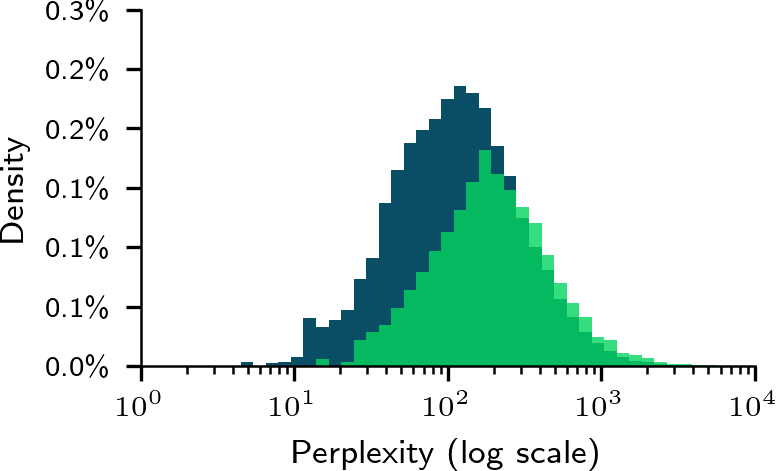

Reproduced: 516.21 ± 828.17
Non-reproduced: 756.11 ± 1411.19


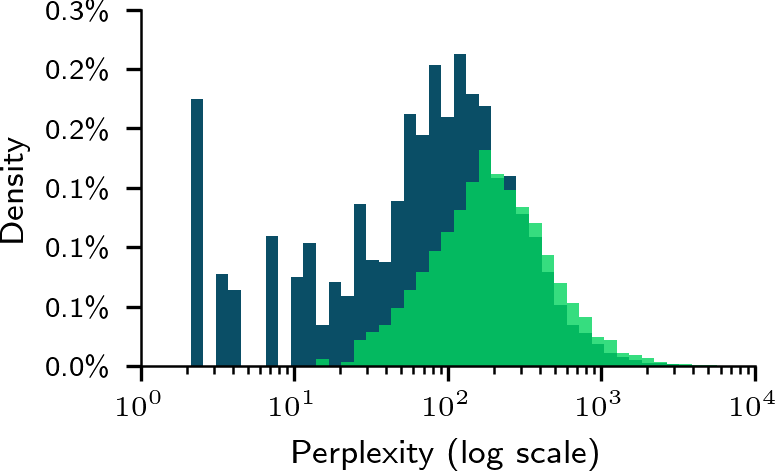

<Figure size 1647.88x58.1154 with 0 Axes>

In [40]:
PERPLEXITY_BASE_DIR = DATA_BASE_DIR / "perplexities"

perplexities = dict()
for model_type in ("models", "humans"):
    current_dir = PERPLEXITY_BASE_DIR / model_type
    perplexities_reproduced = np.load(current_dir / "perplexities_reproduced.npy")
    perplexities_non_reproduced = np.load(current_dir / "perplexities_non_reproduced.npy")
    perplexities[model_type] = {
        "reproduced": perplexities_reproduced,
        "non_reproduced": perplexities_non_reproduced,
    }

for model_type, current_perplexities in perplexities.items():

    perplexities_reproduced = current_perplexities["reproduced"]
    perplexities_non_reproduuced = current_perplexities["non_reproduced"]

    print(f"Reproduced: {np.mean(perplexities_reproduced):.2f} ± {np.std(perplexities_reproduced):.2f}")
    print(f"Non-reproduced: {np.mean(perplexities_non_reproduced):.2f} ± {np.std(perplexities_non_reproduced):.2f}")

    fig, ax = plt.subplots(figsize=plot_util.FIGURE_SIZE_HALF_IN)

    bins = np.logspace(0, 4, 50)

    ax.hist(
        perplexities_reproduced,
        bins=bins,
        alpha=1.0,
        density=True,
        label="Snippets in AuxDataset",
        color="C3",
        log=False,
    )

    ax.hist(
        perplexities_non_reproduced,
        bins=bins,
        alpha=0.8,
        density=True,
        label="Snippets Not in AuxDataset",
        color="C4",
        log=False,
    )

    # plt.legend(loc="upper right")
    ax.set_xlabel("Perplexity (log scale)")
    ax.set_ylabel("Density")
    ax.set_xscale("log")
    ax.set_xlim(1e0, 1e4)
    ax.set_ylim(0, 0.003)

    legend_handles, legend_labels = ax.get_legend_handles_labels()
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=1))

    plt.show(fig)

    fig.savefig(PLOT_OUTPUT_DIR/ f"50_{model_type}.pdf")

    plt.close(fig)

fig_legend = plt.figure(figsize=(plot_util.FIGURE_SIZE_FULL_IN[0], 14.0 / plot_util.TEX_PT_PER_IN))
fig_legend.legend(legend_handles, legend_labels, loc="center", ncol=2)
plt.show()
fig_legend.savefig(PLOT_OUTPUT_DIR / "50_legend.pdf")
plt.close(fig_legend)


In [41]:
MODEL_TYPE_TABLE_MAP = {
    "models": "LLM Generations",
    "humans": "Human-Written Text",
}

for model_type, current_perplexities in perplexities.items():
    perplexities_reproduced = current_perplexities["reproduced"]
    perplexities_non_reproduced = current_perplexities["non_reproduced"]

    mean_reproduced = np.mean(perplexities_reproduced)
    median_reporduced = np.median(perplexities_reproduced)
    mean_non_reproduced = np.mean(perplexities_non_reproduced)
    median_non_reproduced = np.median(perplexities_non_reproduced)
    model_name = MODEL_TYPE_TABLE_MAP[model_type]

    bottom_rule = "" if model_type == "models" else " \\bottomrule"

    print(f"{model_name} & {mean_reproduced:.1f} & {median_reporduced:.1f} & {mean_non_reproduced:.1f} & {median_non_reproduced:.1f} \\\\{bottom_rule}")



LLM Generations & 533.5 & 281.9 & 685.2 & 369.6 \\
Human-Written Text & 516.2 & 277.8 & 756.1 & 414.5 \\ \bottomrule


In [42]:
top_k = 10

for model_type, current_perplexities in perplexities.items():
    # Load snippets
    current_dir = PERPLEXITY_BASE_DIR / model_type
    with open(current_dir / "memorized_snippets.jsonl", "r") as f:
        snippets_reproduced = tuple(json.loads(line) for line in f)
    with open(current_dir / "non_memorized_snippets.jsonl", "r") as f:
        snippets_non_reproduced = tuple(json.loads(line) for line in f)
    all_snippets = snippets_reproduced + snippets_non_reproduced
    all_perplexities = np.concatenate((current_perplexities["reproduced"], current_perplexities["non_reproduced"]))
    assert len(all_snippets) == len(all_perplexities)

    sorted_indices = np.argsort(all_perplexities)
    print(f"Bottom {top_k} snippets for {model_type}:")
    for idx in range(top_k):
        print(f"\\item \\begin{{spverbatim}}{all_snippets[sorted_indices[idx]]}\\end{{spverbatim}}")
    print("---------------------------------")
    print(f"Top {top_k} snippets for {model_type}:")
    for idx in range(top_k):
        print(f"\\item \\begin{{spverbatim}}{all_snippets[sorted_indices[-idx -1]]}\\end{{spverbatim}}")
    print("---------------------------------")


Bottom 10 snippets for models:
\item \begin{spverbatim}1 + \frac{1}{2} + \frac{1}{3} + \cdots + \frac{1}{\end{spverbatim}
\item \begin{spverbatim}else {
      res.send(result);
    }
  });
});

//\end{spverbatim}
\item \begin{spverbatim}content:
```html
<!DOCTYPE html>
<html>
<head>
   \end{spverbatim}
\item \begin{spverbatim}G, H, I, J, L, M, N, O, P, Q, R, S, T, U, V, W, X,\end{spverbatim}
\item \begin{spverbatim}numbers:

0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89,\end{spverbatim}
\item \begin{spverbatim}Of course, there is still a lot of work to be done\end{spverbatim}
\item \begin{spverbatim}font-family: Arial, sans-serif; margin: 0; padding\end{spverbatim}
\item \begin{spverbatim}sequence: 0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89,\end{spverbatim}
\item \begin{spverbatim}frac{3}{6} + \frac{1}{6} = \frac{4}{6} = \frac{2}{\end{spverbatim}
\item \begin{spverbatim}I shook my head. "I don't know what you're talking\end{spverbatim}
---------------------------------
Top 10 snippets for model

## Example prompts

In [43]:
collected_prompts = collections.defaultdict(list)

max_example_prompts = 2

for setting in tqdm.tqdm(RESULTS_DIRS):
    for result_file in tuple((RESULTS_BASE_DIR / setting).glob("*.jsonl")):
        model, temperature_raw = result_file.stem.split("_")
        if model != "claude-3-opus":  # can just use one model
            continue
        with open(result_file, "r") as f:
            for line in f:
                raw_data = json.loads(line)
                type = raw_data["type"]
                if len(collected_prompts[type]) >= max_example_prompts:
                    continue
                prompt, = (message["content"] for message in raw_data["messages"] if message["role"] == "user")
                collected_prompts[type].append(prompt)

for type, type_label in TYPE_LABEL_MAP.items():
    prompts = collected_prompts[type]
    print(rf"\item \textbf{{{type_label}}} ({TEXT_TYPE_LABELS[TYPE_TEXT_TYPE_MAP[type]]})")
    print(r"\begin{itemize}")
    for prompt in prompts:
        print(fr"  \item \texttt{{{prompt}}}")
    print(r"\end{itemize}")


100%|██████████| 8/8 [00:01<00:00,  4.31it/s]

\item \textbf{WritingPrompts} (Creative)
\begin{itemize}
  \item \texttt{Write a story (500 words) based on the following prompt: You are a bartender who can see other people's stress levels. Most people rarely reach a hundred. Seemingly normal individual orders a drink. Their stress level is above a thousand.}
  \item \texttt{Write a story (500 words) based on the following prompt: A cursed, and blood thirsty sword sits there, lying down, ready for new hands. It only knows a life filled with horrible people, and soon a new adventurer comes. But as soon as the adventurers hands grasp the sword, it feels something different than what it knows, something nicer.}
\end{itemize}
\item \textbf{Blog (Travel)} (Creative)
\begin{itemize}
  \item \texttt{Write a fictional travel blog post about a volunteer trip to a developing country.}
  \item \texttt{Write a fictional travel blog post about Rome.}
\end{itemize}
\item \textbf{Blog (Personal)} (Creative)
\begin{itemize}
  \item \texttt{Write a p

## In-the-wild statistics

In [44]:
for dataset, model_counts in df_overview_wild.groupby("dataset"):
    print(rf"\multicolumn{{2}}{{l}}{{{WILD_LEGEND_MAP[dataset]}}} \\")
    for model, counts in model_counts.value_counts("model").sort_index().items():
        print(rf"& {model} & {counts} \\")

print()
print(len(df_overview_wild))

\multicolumn{2}{l}{LMSYS-Chat-1M} \\
& gpt-3.5-turbo & 1728 \\
& gpt-4 & 1645 \\
& llama-2-13b-chat & 10088 \\
& llama-2-7b-chat & 1214 \\
\multicolumn{2}{l}{WildChat} \\
& gpt-3.5-turbo-0125 & 9999 \\
& gpt-3.5-turbo-0301 & 8811 \\
& gpt-3.5-turbo-0613 & 9912 \\
& gpt-4-0125-preview & 9929 \\
& gpt-4-0314 & 9875 \\
& gpt-4-1106-preview & 9638 \\

72839


## Distribution of reproduction lengths

In [45]:
current_models = (
    "gpt-4o-mini-2024-07-18", "gpt-4o-2024-05-13", "gpt-4-turbo-2024-04-09",
    "claude-3-haiku", "claude-3.5-sonnet", "claude-3-opus",
    "llama-3.1-8b-instruct" ,"llama-3.1-70b-instruct" ,"llama-3.1-405b-instruct",
    "gemini-1.5-flash-002", "gemini-1.5-pro-002",
    # "o1-mini-2024-09-12", "o1-preview-2024-09-12",
)
current_ignored_settings = (
    "ablation_assistant",
    "ablation_simple",
)

current_data = []
for setting in tqdm.tqdm(RESULTS_DIRS):
    if setting in current_ignored_settings:
        continue
    for result_file in tuple((RESULTS_BASE_DIR / setting).glob("*.jsonl")):
        model, temperature_raw = result_file.stem.split("_")
        temperature = float(temperature_raw[len("temp"):]) if temperature_raw != "tempX.X" else None
        # if temperature is not None and temperature != DEFAULT_TEMPERATURE:
        #     continue
        if model not in current_models:
            continue
        with open(result_file, "r") as f:
            for line in f:
                raw_data = json.loads(line)
                if "error" in raw_data:
                    continue
                if is_refusal(raw_data["completion"]):
                    continue
                # Special case, drop old IMDB reviews
                if setting == "imdb_reviews" and model == "humans" and datetime.date.fromisoformat(raw_data["review_date"]) < IMDB_REVIEW_DATE_MIN:
                    continue
                memorized_fraction = np.mean(np.array(raw_data["memorized_chars"]) >= MEMORIZATION_THRESHOLD)
                max_reproduction_length = max(raw_data["memorized_chars"])
                current_data.append({
                    "model": model,
                    "type": raw_data["type"],
                    "memorized_fraction": memorized_fraction,
                    "max_reproduction_length": max_reproduction_length,
                    "text_type": raw_data["text_type"],
                    "temperature": temperature,
                })

df_distributions_aux = pd.DataFrame(current_data)
del current_data

100%|██████████| 8/8 [00:24<00:00,  3.07s/it]


Temperature (0.0,): 0.8 quantile: 62.0
Temperature (0.0,): 0.95 quantile: 77.0
Temperature (0.0,): 0.99 quantile: 102.33000000000175
Temperature (0.0,): 0.999 quantile: 182.16499999998632
Temperature (0.7,): 0.8 quantile: 66.0
Temperature (0.7,): 0.95 quantile: 86.0
Temperature (0.7,): 0.99 quantile: 125.0
Temperature (0.7,): 0.999 quantile: 248.29200000000856
Temperature (0.0, 0.7): 0.8 quantile: 64.0
Temperature (0.0, 0.7): 0.95 quantile: 82.0
Temperature (0.0, 0.7): 0.99 quantile: 115.0
Temperature (0.0, 0.7): 0.999 quantile: 220.0


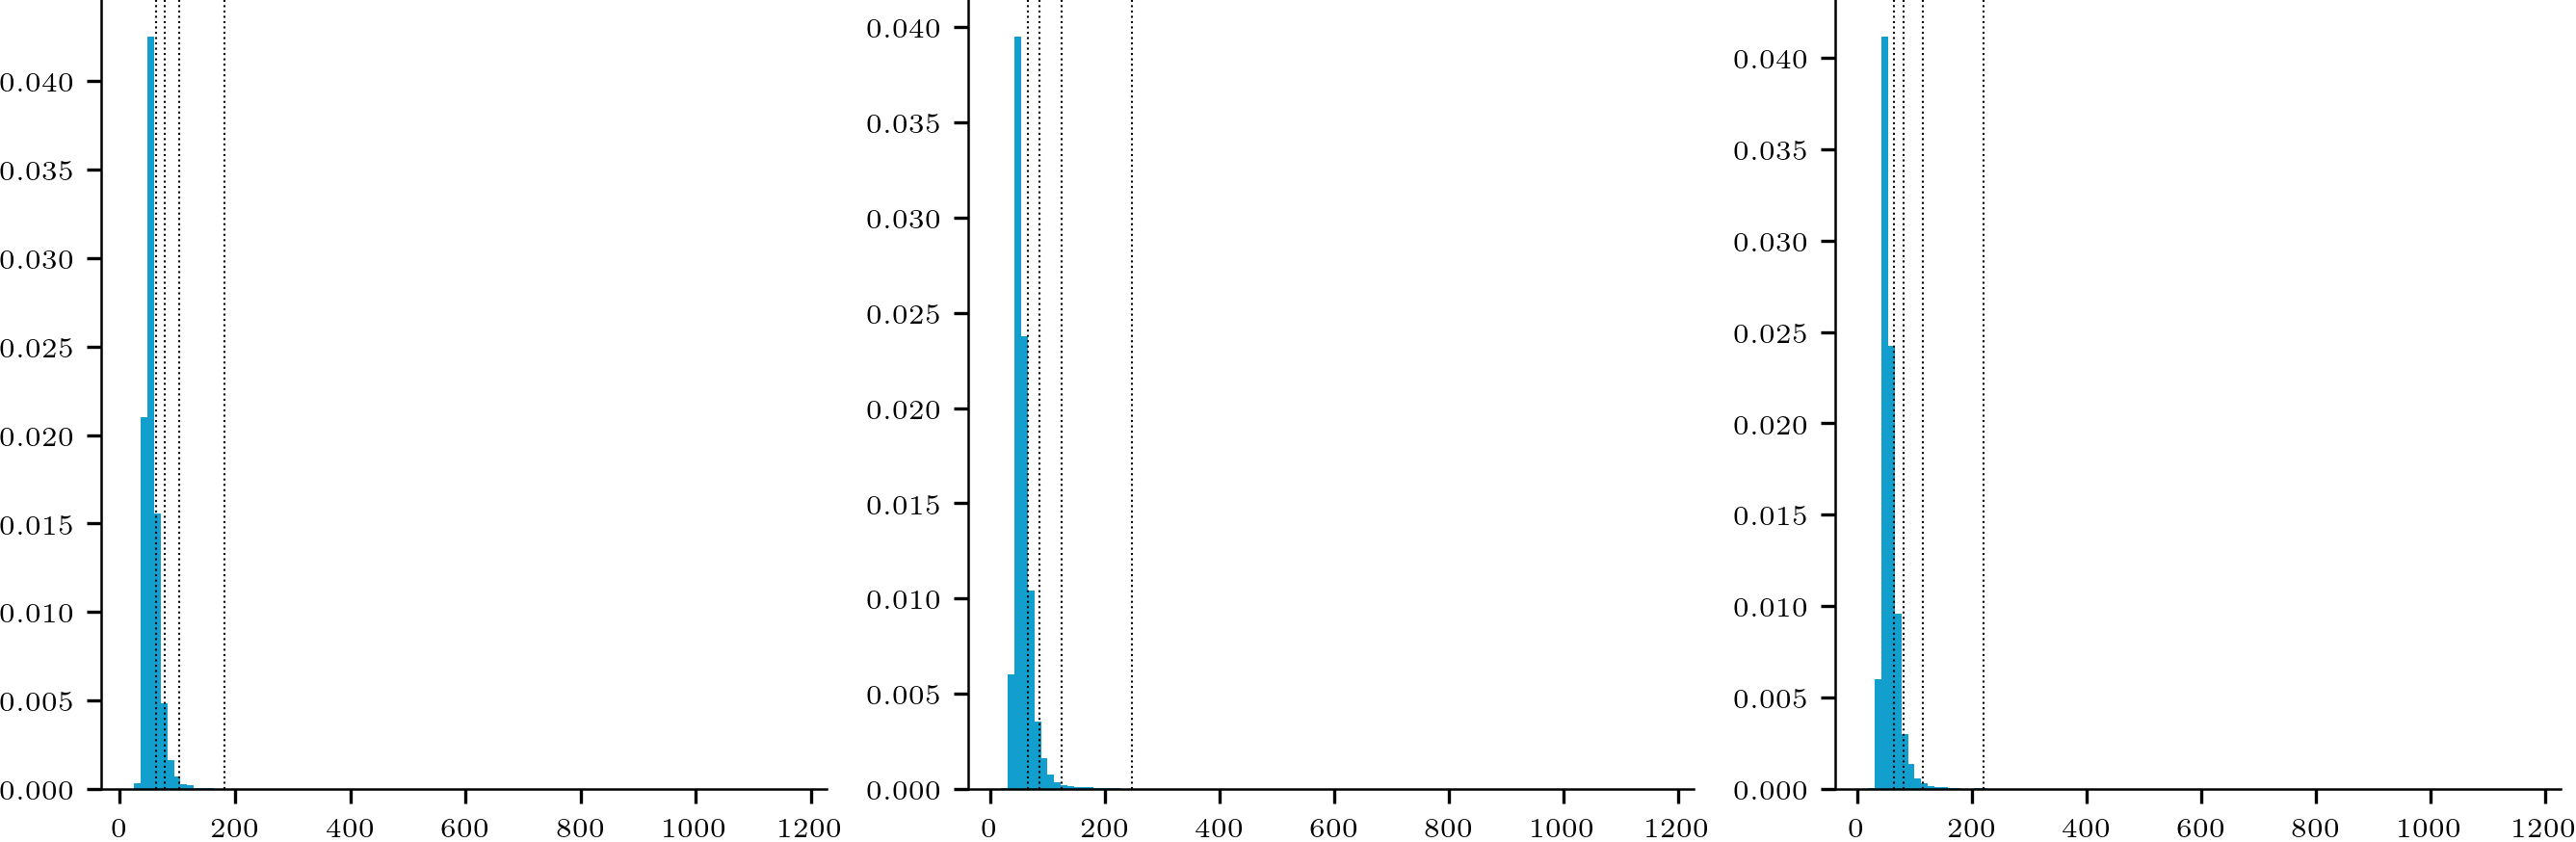

In [46]:
TEMPERATURE_SETS = ((0.0,), (0.7,), (0.0, 0.7))
QUANTILES = (0.8, 0.95, 0.99, 0.999)

fig, axes = plt.subplots(1, len(TEMPERATURE_SETS), figsize=(3 * len(TEMPERATURE_SETS), 3))
for ax, temperature_set in zip(axes, TEMPERATURE_SETS):
    current_values = df_distributions_aux[df_distributions_aux["temperature"].isin(temperature_set)]["max_reproduction_length"]
    ax.hist(current_values, bins=100, density=True)
    for quantile in QUANTILES:
        current_quantile_value = np.quantile(current_values, quantile)
        # Plot quantile with label
        ax.axvline(current_quantile_value, color="black", linestyle="dotted", lw=0.5)
        print(f"Temperature {temperature_set}: {quantile} quantile: {current_quantile_value}")


## Longest extracted sequences

In [47]:
current_models = (
    "gpt-4o-mini-2024-07-18", "gpt-4o-2024-05-13", "gpt-4-turbo-2024-04-09",
    "claude-3-haiku", "claude-3.5-sonnet", "claude-3-opus",
    "llama-3.1-8b-instruct" ,"llama-3.1-70b-instruct" ,"llama-3.1-405b-instruct",
    "gemini-1.5-flash-002", "gemini-1.5-pro-002",
    "o1-mini-2024-09-12", "o1-preview-2024-09-12",
)
current_ignored_settings = ()

current_data = []
for setting in tqdm.tqdm(RESULTS_DIRS):
    if setting in current_ignored_settings:
        continue
    for result_file in tuple((RESULTS_BASE_DIR / setting).glob("*.jsonl")):
        model, temperature_raw = result_file.stem.split("_")
        temperature = float(temperature_raw[len("temp"):]) if temperature_raw != "tempX.X" else None
        # if temperature is not None and temperature != DEFAULT_TEMPERATURE:
        #     continue
        if model not in current_models:
            continue
        with open(result_file, "r") as f:
            for line in f:
                raw_data = json.loads(line)
                if "error" in raw_data:
                    continue
                if is_refusal(raw_data["completion"]):
                    continue
                # Special case, drop old IMDB reviews
                if setting == "imdb_reviews" and model == "humans" and datetime.date.fromisoformat(raw_data["review_date"]) < IMDB_REVIEW_DATE_MIN:
                    continue
                memorization_lengths = np.array(raw_data["memorized_chars"])
                # memorized_fraction = np.mean(memorization_lengths >= MEMORIZATION_THRESHOLD)
                max_reproduction_idx = np.argmax(memorization_lengths)
                max_reproduction_length = memorization_lengths[max_reproduction_idx]
                max_snippet = raw_data["completion"][max_reproduction_idx:max_reproduction_idx + max_reproduction_length]
                prompt, = (message["content"] for message in raw_data["messages"] if message["role"] == "user")
                current_data.append({
                    "model": model,
                    "type": raw_data["type"],
                    # "memorized_fraction": memorized_fraction,
                    "max_reproduction_length": max_reproduction_length,
                    "max_snippet": max_snippet,
                    "text_type": raw_data["text_type"],
                    "temperature": temperature,
                    "prompt": prompt,
                })

df_max_sequences = pd.DataFrame(current_data)
del current_data

100%|██████████| 8/8 [00:35<00:00,  4.47s/it]


In [48]:
df_print = df_max_sequences[(df_max_sequences["temperature"] == DEFAULT_TEMPERATURE) | (df_max_sequences["model"].str.startswith("o1"))].copy()
df_print = df_print.groupby(["model"])
for model_key in MODEL_ORDER:
    if model_key not in df_print.groups:
        continue
    model_data = df_print.get_group(model_key)
    # Get longest snippet
    longest_snippet_idx = model_data["max_reproduction_length"].argmax()
    model_data = model_data.iloc[longest_snippet_idx]
    prompt_type = model_data["text_type"]
    prompt = model_data["prompt"]
    snippet_length = model_data["max_reproduction_length"]
    snippet = model_data["max_snippet"]
    print(f"{MODEL_NAMES[model_key]}:")
    print(rf"""\begin{{itemize}}
\item Prompt type: {prompt_type}
\item Memorized string length: {snippet_length}
\item Prompt: \begin{{spverbatim}}{prompt}\end{{spverbatim}}
\item Longest reproduced sequence in generation: \begin{{spverbatim}}{snippet}\end{{spverbatim}}
\end{{itemize}}""")
    print()


GPT-4o-mini:
\begin{itemize}
\item Prompt type: expository
\item Memorized string length: 513
\item Prompt: \begin{spverbatim}Write a tutorial about computer vision.\end{spverbatim}
\item Longest reproduced sequence in generation: \begin{spverbatim}for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

       \end{spverbatim}
\end{itemize}

GPT-4o:
\begin{itemize}
\item Prompt type: expository
\item Memorized string length: 605
\item Prompt: \begin{spverbatim}Write a tutorial about the transformer neural network architecture.\end{spverbatim}
\

/tmp/ipykernel_3081110/966471265.py:6: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  model_data = df_print.get_group(model_key)


In [49]:
current_models = (
    "gpt-4o-mini-2024-07-18", "gpt-4o-2024-05-13", "gpt-4-turbo-2024-04-09",
    "claude-3-haiku", "claude-3.5-sonnet", "claude-3-opus",
    "llama-3.1-8b-instruct" ,"llama-3.1-70b-instruct" ,"llama-3.1-405b-instruct",
    "gemini-1.5-flash-002", "gemini-1.5-pro-002",
    "o1-mini-2024-09-12", "o1-preview-2024-09-12",
)
current_ignored_settings = ()

current_data = []
for setting in tqdm.tqdm(RESULTS_DIRS):
    if setting in current_ignored_settings:
        continue
    for result_file in tuple(sorted((RESULTS_BASE_DIR / setting).glob("*.jsonl"))):
        model, temperature_raw = result_file.stem.split("_")
        temperature = float(temperature_raw[len("temp"):]) if temperature_raw != "tempX.X" else None
        # if temperature is not None and temperature != DEFAULT_TEMPERATURE:
        #     continue
        if model not in current_models:
            continue
        current_results = []
        with open(result_file, "r") as f:
            for line in f:
                raw_data = json.loads(line)
                if "error" in raw_data:
                    continue
                if is_refusal(raw_data["completion"]):
                    continue
                # Special case, drop old IMDB reviews
                if setting == "imdb_reviews" and model == "humans" and datetime.date.fromisoformat(raw_data["review_date"]) < IMDB_REVIEW_DATE_MIN:
                    continue
                if not np.any(np.array(raw_data["memorized_chars"]) >= MEMORIZATION_THRESHOLD):
                    continue
                candidate_idx = np.argwhere(np.array(raw_data["memorized_chars"]) >= MEMORIZATION_THRESHOLD)[0, 0]
                current_results.append(raw_data["completion"][candidate_idx:candidate_idx + MEMORIZATION_THRESHOLD])

        current_data.append({
            "model": model,
            "type": raw_data["type"],
            "snippets": current_results,
            "text_type": raw_data["text_type"],
            "temperature": temperature,
        })

df_snippets = pd.DataFrame(current_data)
del current_data

100%|██████████| 8/8 [00:40<00:00,  5.10s/it]


In [50]:
rng = np.random.default_rng(seed=0xc0ffee)
for model in MODEL_ORDER:
    if model not in df_snippets["model"].unique():
        continue
    df_current = df_snippets[df_snippets["model"] == model]
    if not model.startswith("o1"):
        df_current = df_current[df_current["temperature"] == DEFAULT_TEMPERATURE]
    all_snippets = np.concatenate(df_current["snippets"].values)
    selected_snippets = rng.choice(all_snippets, size=10, replace=False)
    print(f"{MODEL_NAMES[model]}:")
    print(r"\begin{itemize}")
    for snippet in selected_snippets:
        print(rf"\item \begin{{spverbatim}}{snippet}\end{{spverbatim}}")
    print(r"\end{itemize}")
    print()



GPT-4o-mini:
\begin{itemize}
\item \begin{spverbatim} citing "unforeseen circumstances" as the reason f\end{spverbatim}
\item \begin{spverbatim} is an absolute masterpiece that has stood the tes\end{spverbatim}
\item \begin{spverbatim} 21.34 seconds set by Florence Griffith-Joyner in \end{spverbatim}
\item \begin{spverbatim}, I can still feel the adrenaline coursing through\end{spverbatim}
\item \begin{spverbatim}I hope this letter finds you in good health and hi\end{spverbatim}
\item \begin{spverbatim}, marked the first total solar eclipse to cross th\end{spverbatim}
\item \begin{spverbatim} is essential for the long-term economic stability\end{spverbatim}
\item \begin{spverbatim}I hope this letter finds you well. I am writing to\end{spverbatim}
\item \begin{spverbatim} is a disappointing conclusion to what was an othe\end{spverbatim}
\item \begin{spverbatim} that seem to serve no purpose other than to infla\end{spverbatim}
\end{itemize}

GPT-4o:
\begin{itemize}
\item \begin{spverbati